In [1]:
import numpy as np
import pandas as pd
import h5py
from fitsio import FITS
from astropy.table import Table, setdiff, vstack, join_skycoord, join
from astropy.coordinates import SkyCoord
import re
from glob import glob


import matplotlib.pyplot as plt
plt.style.use('MNRAS.mplstyle')

h = 0.7

filepath = r"/bsuhome/gladyskamau/BSU-Research/Cardinal/Data/"

file_path = r"/bsuscratch/shuleicao/Cardinalv3/"

## Load halos
Here we load the halos from the correctedfile that have a match in the gold catalog so as to the ra and dec coordinates.

In [2]:
halos =  Table(np.load(filepath+"halos_cardinal_w_lensing_1687.npy"))
print(len(halos))
print(halos.columns)
halos[:4]

648278
<TableColumns names=('haloid','Mvir','Rvir','M200m','R200m','rho','DeltaSigma','Sigma','ra','dec','Redshift','pixel_id','comoving_dis','Angular_dis','coadd_object_id')>


haloid,Mvir,Rvir,M200m,R200m,rho,DeltaSigma,Sigma,ra,dec,Redshift,pixel_id,comoving_dis,Angular_dis,coadd_object_id
int64,float32,float64,float32,float64,float64[10],float64[15],float64[15],float32,float32,float64,int64,float64,float64,int64
2545389,68890000000000.0,1.028330532212885,91154710000000.0,1.11086,2219173286702298.8 .. 1519260804499.2036,4.6287534375558955e+25 .. 9.332134904079599e+23,1.8686427109243654e+26 .. 6.087507443686441e+24,307.15073,-42.051777,0.270594,10285,761.9494453759291,599.6796731928298,86000938027
2545393,88940000000000.0,1.119819607843137,105052300000000.0,1.16474,1642214180825270.8 .. 920412980488.0205,-4.994613625995734e+25 .. 9.322161005349066e+23,2.1990513980065593e+26 .. 6.140081006044497e+24,307.27472,-42.053135,0.270768,10285,762.4068156651239,599.9574809591755,86000938026
2545753,76890000000000.0,1.073595708639187,81108270000000.0,1.06845,2128660225006729.0 .. 356406746880.90045,2.95140595076031e+25 .. 3.691992796737854e+23,2.144910026489099e+26 .. 6.539685022643195e+24,308.46567,-39.823948,0.264409,10158,745.6642443889294,589.733272327303,86000938014
2546147,52410000000000.0,0.9459356295878034,56695420000000.0,0.948232,1624285805491000.8 .. 317631813489.1384,-9.316642660689926e+24 .. -7.316801476510358e+23,2.1863243391727287e+26 .. 7.803042089398711e+24,307.48544,-41.11823,0.269426,10285,758.8781845754792,597.812012233789,86000938035


In [ ]:
# ## Comoving distance of the halos
# from colossus.cosmology import cosmology
# from astropy.cosmology import FlatLambdaCDM
# astropy_cosmo = FlatLambdaCDM(H0=70, Om0=0.286,Ob0 = 0.047) # Does not incorporate h due to the non-normalized H0 value defined.
# col_cosmo = cosmology.fromAstropy(astropy_cosmo,sigma8 = 0.82, ns= 0.96, cosmo_name='col_cosmo')

# halos_1687['comoving_dis'] = col_cosmo.comovingDistance(z_max=halos_1687['Redshift'], transverse=False)
# halos_1687['Angular_dis'] = col_cosmo.angularDiameterDistance(halos_1687['Redshift']) 
# halos_1687[:5]

# np.save('Data/halos_cardinal_w_lensing_1687.npy', halos_1687)

In [ ]:
## Convert all the ra and dec of skysim halos to pixel id
import healpy as hp
nside = 8
pixelId = []   #162
for i in range(len(halos_1687)):
    pixel_id = hp.pixelfunc.ang2pix(nside, halos_1687['ra'][i], halos_1687['dec'][i], lonlat=True)
    pixelId.append(pixel_id)
print(len(pixelId),'\n', len(np.unique(pixelId)))

halos_1687['pixel_id'] = pixelId
len(np.unique(halos_1687['pixel_id']))

# np.save(file_path1 + 'halos_cardinal_w_lensing_8.npy', halos_1687)

## Load the gold catalog

In [24]:
#### getting redshift of the galaxies
fname = file_path + 'Cardinal-3_v2.0_Y6a_bpz.h5'
f = h5py.File(fname,'r')
print(f.keys())
catalog = f['catalog']
print(catalog.keys())
gold = catalog['bpz']
print(gold.keys())
print(len(gold['z']))
cosm_z = gold['redshift_cos'][:]
coadd_object_id_z = gold['coadd_object_id'][:]
print(len(cosm_z))

<KeysViewHDF5 ['catalog']>
<KeysViewHDF5 ['bpz']>
<KeysViewHDF5 ['coadd_object_id', 'redshift_cos', 'z', 'zmc_sof', 'zmean_sof', 'zsigma_sof']>
1399546088
1399546088


In [26]:
#### getting halos with positional quantities (coordinates)
fname = file_path + 'Cardinal-3_v2.0_Y6a_gold.h5'
f = h5py.File(fname,'r')
print(f.keys())
catalog = f['catalog']
print(catalog.keys())
gold = catalog['gold']
print(len(gold['rhalo']))
print(gold.keys())
rhalo = gold['rhalo'][:]
sel = (rhalo == 0)  # Central halos

ra_all = gold['ra'][:]
dec_all = gold['dec'][:]
haloid_all = gold['haloid'][:]
m200_all = gold['m200'][:]
coadd_object_id = gold['coadd_object_id'][:]

ra = ra_all[sel]
dec = dec_all[sel]
haloid = haloid_all[sel]
m200 = m200_all[sel]
galaxyid = coadd_object_id[sel]
cosm_zsel1 = cosm_z[sel]
print(len(ra))

<KeysViewHDF5 ['catalog', 'masks']>
<KeysViewHDF5 ['gold']>
1399546088
<KeysViewHDF5 ['coadd_object_id', 'dec', 'flags_gold', 'flux_g', 'flux_i', 'flux_r', 'flux_z', 'haloid', 'hpix_16384', 'ivar_g', 'ivar_i', 'ivar_r', 'ivar_z', 'm200', 'mag_err_g', 'mag_err_i', 'mag_err_r', 'mag_err_z', 'mag_g', 'mag_g_lensed', 'mag_g_lensed_old', 'mag_g_true', 'mag_i', 'mag_i_lensed', 'mag_i_lensed_old', 'mag_i_true', 'mag_r', 'mag_r_lensed', 'mag_r_lensed_old', 'mag_r_true', 'mag_z', 'mag_z_lensed', 'mag_z_lensed_old', 'mag_z_true', 'mcal_flux_g', 'mcal_flux_i', 'mcal_flux_r', 'mcal_flux_z', 'mcal_ivar_g', 'mcal_ivar_i', 'mcal_ivar_r', 'mcal_ivar_z', 'px', 'py', 'pz', 'r200', 'ra', 'rhalo', 'sdss_sedid', 'vx', 'vy', 'vz']>
472059983


In [28]:
## Lets select the halos whose mass>0
sel = (m200>0)

ra = ra[sel]
dec = dec[sel]
haloid = haloid[sel]
m200 = m200[sel]
galaxyid = galaxyid[sel]
cosm_zsel1 = cosm_zsel1[sel]

dictt = {'haloid': haloid,
         'ra': ra,
        'dec': dec,
         'cosm_z': cosm_zsel1,
         'Mvir': m200,
        'coadd_object_id': galaxyid}
gold = pd.DataFrame(dictt)
print(len(gold))
gold.head()

3025241


,haloid,ra,dec,cosm_z,Mvir,coadd_object_id
0,10259160,45.042305,0.036648,0.122800,9.980000e+12,364000000749
1,34071991,45.023640,0.048814,0.678106,1.186000e+13,364004949061
2,34282003,44.981236,0.043225,0.902740,8.771000e+12,364008150570
3,24147650,45.071865,0.065430,0.480547,1.413000e+13,364002802488
4,34283670,45.095184,0.089323,0.780603,7.146000e+12,364005998568


In [1]:
## Checking if the haloid is unqiue, its not
len(haloid), len(np.unique(haloid)), len(halos['haloid']), len(np.unique(halos['haloid']))

NameError: name 'haloid' is not defined

In [29]:
# np.save(filepath + "halos_Mvirgreatthan0_3025241.npy",Table.from_pandas(gold))

In [80]:
halos2 = join(halos, Table.from_pandas(gold), keys=['haloid','Mvir'], join_type='inner')
halos2['Sigma'] = halos2['Sigma']*1e12*h
halos2['DeltaSigma'] = halos2['DeltaSigma']*1e12*h
print(len(halos2))
# halos2[:5]

648278


In [ ]:
## Convert all the ra and dec of skysim halos to pixel id
import healpy as hp
nside = 32
pixelId = []   #162
for i in range(len(halos2)):
    pixel_id = hp.pixelfunc.ang2pix(nside, halos2['ra'][i], halos2['dec'][i], lonlat=True)
    # print(hpix)
    pixelId.append(pixel_id)
print(len(pixelId),'\n', len(np.unique(pixelId)))

halos2['pixel_id'] = pixelId
len(np.unique(halos2['pixel_id']))

In [10]:
halos = Table(np.load(filepath + "halos_cardinal_w_lensing_1687.npy"))
print(len(halos), halos['Mvir'].min())
halos[:4]

648278 10010000000000.0


haloid,Mvir,Rvir,M200m,R200m,rho,DeltaSigma,Sigma,ra,dec,Redshift,pixel_id,comoving_dis,Angular_dis,coadd_object_id
int64,float32,float64,float32,float64,float64[10],float64[15],float64[15],float32,float32,float64,int64,float64,float64,int64
2545389,68890000000000.0,1.028330532212885,91154710000000.0,1.11086,2219173286702298.8 .. 1519260804499.2036,4.6287534375558955e+25 .. 9.332134904079599e+23,1.8686427109243654e+26 .. 6.087507443686441e+24,307.15073,-42.051777,0.270594,10285,1088.499207679904,856.6853044165988,86000938027
2545393,88940000000000.0,1.119819607843137,105052300000000.0,1.16474,1642214180825270.8 .. 920412980488.0205,-4.994613625995734e+25 .. 9.322161005349066e+23,2.1990513980065593e+26 .. 6.140081006044497e+24,307.27472,-42.053135,0.270768,10285,1089.1525938073237,857.0821690562902,86000938026
2545753,76890000000000.0,1.073595708639187,81108270000000.0,1.06845,2128660225006729.0 .. 356406746880.90045,2.95140595076031e+25 .. 3.691992796737854e+23,2.144910026489099e+26 .. 6.539685022643195e+24,308.46567,-39.823948,0.264409,10158,1065.2346348413303,842.4763148959951,86000938014
2546147,52410000000000.0,0.9459356295878034,56695420000000.0,0.948232,1624285805491000.8 .. 317631813489.1384,-9.316642660689926e+24 .. -7.316801476510358e+23,2.1863243391727287e+26 .. 7.803042089398711e+24,307.48544,-41.11823,0.269426,10285,1084.1116922506944,854.017242636195,86000938035


In [7]:
# halos2 = join(halos, Table.from_pandas(gold), keys=['haloid','Mvir','ra','dec'], join_type='inner')
# halos2['Sigma'] = halos2['Sigma']*1e12*h
# halos2['DeltaSigma'] = halos2['DeltaSigma']*1e12*h
# print(len(halos2))
# halos2[:5]

In [12]:
# np.save(filepath + "halos_cardinal_w_lensing_1687.npy",halos2)

## Load redMaPPer catalog

In [2]:
### Clusters
redmapper_file = FITS(file_path+"redmapper_v4_v8_v51_y6_v7/run/Cardinal-3Y6a_v2.0_run_run_redmapper_v0.8.1_lgt20_vl02_catalog.fit", mode=0)
redmapper = Table(redmapper_file[1].read())
print(len(redmapper))
redmapper[:5]

NameError: name 'FITS' is not defined

In [13]:
### Cluster members
import random
redmapper_me = FITS(file_path+"redmapper_v4_v8_v51_y6_v7/run/Cardinal-3Y6a_v2.0_run_run_redmapper_v0.8.1_lgt20_vl02_catalog_members.fit", mode=0)
redmapper_me = Table(redmapper_me[1].read())
print(len(redmapper_me))
redmapper_me[random.sample(range(len(redmapper_me)), 5)]

1043744


mem_match_id,id,z,ra,dec,r,p,pfree,pcol,theta_i,theta_r,refmag,refmag_err,zred,zred_e,zred_chisq,chisq,ebv,zspec,mag,mag_err
int32,int64,float32,float64,float64,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32[4],float32[4]
8212,106004799353,0.65530795,11.100097134395067,-33.922737786196336,0.5995827,0.53138244,1.0,0.5406876,1.0,0.999998,20.650373,0.02998446,0.70258933,0.027385158,0.0,4.2446437,0.0,0.68367565,24.058987 .. 20.650373,0.08707656 .. 0.02998446
20865,43003927805,0.64681685,95.66129208896055,-46.14581624814545,0.186822,0.85179466,1.0,0.75980365,1.0,1.0,21.438244,0.046563823,0.5929521,0.032578047,0.0,2.177309,0.0,0.5858637,24.37331 .. 21.438244,0.12967896 .. 0.046563823
37168,122005903360,0.8068443,14.294443973469738,-60.8028428199118,0.76240426,0.2284564,1.0,0.0,0.9666599,0.28120273,22.427967,0.090508945,0.7461331,0.059620004,0.0,1.5371335,0.0,0.81917936,25.793932 .. 22.427967,0.35669845 .. 0.090508945
19328,380009844578,0.8120219,17.120524724136082,-19.029473877154956,0.46431133,0.5923943,1.0,0.5543759,1.0,1.0,21.374643,0.04087493,0.8155642,0.04165062,0.0,2.5358992,0.0,0.82126373,24.728937 .. 21.374643,0.147984 .. 0.04087493
92,14006094263,0.7384522,65.28001497750208,-26.94601454163964,0.84243107,0.18385218,1.0,0.2595448,1.0,1.0,21.811647,0.05636796,0.8076869,0.029480916,0.0,9.184087,0.0,0.75463694,24.73138 .. 21.811647,0.16891155 .. 0.05636796


In [14]:
#vl02 volume limited sample, 0.2L_* cut
#vl50 full sample 


# Matching Halos with redMaPPer clusters

## Method 1
Matching using `ra` and `dec` then using a projected distance (radius)

In [6]:
import astropy.units as u
from astropy.coordinates import SkyCoord

def calculate_angular_separation(cl_ra, cl_dec, ha_ra2, ha_dec):
    cluster_coords = SkyCoord(ra=cl_ra, dec=cl_dec, unit='deg')
    halo_coords = SkyCoord(ra=ha_ra2, dec=ha_dec, unit='deg')
    separation = cluster_coords.separation(halo_coords)
    return separation
calculate_angular_separation(cl_ra=2.896798269949837,cl_dec=-1.5203787028802902,ha_ra2=2.8949591873192695,ha_dec=-1.5172599429600495)

<Angle 0.00362029 deg>

In [7]:
redmapper.columns#, redmapper.dtype

<TableColumns names=('mem_match_id','ra','dec','z','refmag','refmag_err','lambda','lambda_e','z_lambda','z_lambda_e','cg_spec_z','z_spec_init','z_init','r_lambda','r_mask','scaleval','maskfrac','zred','zred_e','zred_chisq','chisq','z_lambda_niter','ebv_mean','lnlamlike','lncglike','lnlike','ra_orig','dec_orig','w','dlambda_dz','dlambda_dz2','dlambdavar_dz','dlambdavar_dz2','z_lambda_raw','z_lambda_e_raw','bkg_local','lim_exptime','lim_limmag','lim_limmag_hard','lambda_c','lambda_ce','ncent_good','maskgal_index','mag','mag_err','pzbins','pz','ra_cent','dec_cent','id_cent','lambda_cent','zlambda_cent','p_cen','q_cen','p_fg','q_miss','p_sat','p_c')>

In [10]:
halos.columns #, halos2.dtype

<TableColumns names=('haloid','Mvir','Rvir','M200m','R200m','rho','DeltaSigma','Sigma','ra','dec','Redshift','pixel_id')>

In [11]:
halos = halos['haloid', 'Mvir', 'Rvir', 'M200m','R200m','rho','DeltaSigma','Sigma','ra','dec', 'Redshift','pixel_id']
print(len(halos.columns))
redmapper = redmapper['mem_match_id','ra','dec','z','lambda']
print(len(redmapper.columns))

12
5


In [12]:
col_names = ['haloid','Mvir','Rvir','M200m','R200m','rho','DeltaSigma','Sigma','ra','dec', 'Redshift', 'pixel_id', 'mem_match_id','ra_cl','dec_cl','z','lambda']
print(len(col_names))
data_types = ['<i8', '<f4', '<f8', '<f4', '<f8', '<f8', '<f8','<f8', '>f4', '>f4','>f4','>i4','>i4','>f8', '>f8', '>f4', '>f4']
print(len(data_types))

17
17


In [59]:
halos['dec'][:5], np.round(redmapper['dec'],6)

(<Column name='dec' dtype='float32' length=5>
 -42.051777
 -42.053135
 -39.823948
  -41.11823
 -40.337048,
 array([  5.316022,   4.930399,   4.965605, ..., -65.117045, -64.191289,
        -67.06044 ], dtype='>f8'))

In [61]:
halos[np.isin(halos['dec'],np.round(redmapper['dec'],8))]

haloid,Mvir,Rvir,M200m,R200m,rho,DeltaSigma,Sigma,ra,dec,Redshift,pixel_id
int64,float32,float64,float32,float64,float64[10],float64[15],float64[15],float32,float32,float64,int64


In [14]:
### Perfect Match
centered_clusters = join(redmapper, halos, keys=['ra','dec'], table_names=['redMaPPer', 'Halos'])
centered_clusters

mem_match_id,ra,dec,z,lambda,haloid,Mvir,Rvir,M200m,R200m,rho,DeltaSigma,Sigma,Redshift,pixel_id
int32,float64,float64,float32,float32,int64,float32,float64,float32,float64,float64[10],float64[15],float64[15],float64,int64


In [12]:
from astropy.table import join, Table
from astropy.coordinates import SkyCoord
from astropy import units as u

def match_clusters_to_halos(redMaPPer_clusters, Halos):
    # Perform a perfect join based on 'ra' and 'dec'
#     centered_clusters = join(redMaPPer_clusters, Halos, keys=['ra','dec'], table_names=['redMaPPer', 'Halos'])
#     print(len(centered_clusters))
    
#     print(len(centered_clusters)) #, len(centered_clusters)
    print(len(Halos), len(redMaPPer_clusters))
    # Match miscentered clusters
    unmatched_halos = Halos  # [~np.isin(Halos['haloid'],centered_clusters['haloid'])]
    # print("Number of unmatched halos:", len(unmatched_halos))
    sorted_indices_halos = unmatched_halos['M200m'].argsort()[::-1]
    
    miscentered_clusters = redMaPPer_clusters #[~np.isin(redMaPPer_clusters['mem_match_id'],centered_clusters['mem_match_id'])]
    # print(len(miscentered_clusters))
    sorted_indices_cl = miscentered_clusters['lambda'].argsort()[::-1]
    
    
    halo_clusters = []
    
    for index in sorted_indices_halos:
        halo = unmatched_halos[index]
        # Search for halos within redshift separation and projected distance range
        delta_z = (abs(halo['Redshift'] - miscentered_clusters['z']) <= 0.05)
        separation = (calculate_angular_separation(cl_ra=miscentered_clusters['ra'], cl_dec=miscentered_clusters['dec'],
                                                   ha_ra2=halo['ra'], ha_dec=halo['dec']) <= 0.03 * u.deg)
        candidate_clusters = miscentered_clusters[delta_z & separation]
        
        halo_clusters = []
        if len(candidate_clusters)>0:
            matched_clusters = candidate_clusters[candidate_clusters['lambda'].argmax()]
            # print(matched_clusters)
            # print(halo)
            matched_clusters = np.array(list(matched_clusters), dtype=object)
            halo = np.array(list(halo), dtype=object)
            halo_clusters.append(np.hstack((halo,matched_clusters)))
        

    for index in sorted_indices_cl:
        cluster = miscentered_clusters[index]
        # Search for halos within redshift separation and projected distance range
        delta_z = (abs(cluster['z'] - unmatched_halos['Redshift']) <= 0.05)
        separation = (calculate_angular_separation(cl_ra=cluster['ra'], cl_dec=cluster['dec'],
                                                   ha_ra2=unmatched_halos['ra'], ha_dec=unmatched_halos['dec']) <= 0.03 * u.deg)
        candidate_halos = unmatched_halos[delta_z & separation]
        
        if len(candidate_halos)>0:
            matched_halos = candidate_halos[candidate_halos['M200m'].argmax()]
            # print(cluster['ra','dec','redshift'])
            # print(matched_halos['ra','dec','redshift'])
            matched_halos = np.array(list(matched_halos), dtype=object)
            cluster = np.array(list(cluster), dtype=object)
            halo_clusters.append(np.hstack((matched_halos, cluster)))
    
    matching_2 = Table(rows=halo_clusters, names=col_names, dtype=data_types)
        
    print(len(matching_2))
    
    return matching_2  #4579


In [13]:
matching_2 = match_clusters_to_halos(redmapper, halos2)

648278 15755
8491


In [2]:
# np.save('Data/halos_redmapper.npy',matching_2)
halos_redmapper = Table(np.load("Data/halos_redmapper.npy"))
print(len(halos_redmapper))
halos_redmapper[:5]

8491


haloid,Mvir,Rvir,M200m,R200m,rho,DeltaSigma,Sigma,ra,dec,Redshift,pixel_id,mem_match_id,ra_cl,dec_cl,z,lambda
int64,float32,float64,float32,float64,float64[10],float64[15],float64[15],float32,float32,float32,int32,int32,float64,float64,float32,float32
32968839,629500000000000.0,1.8059279038718288,673552500000000.0,2.16384,6908094625823419.0 .. 8749849242628.244,86385936863844.36 .. 137100488103.00998,2495022402212197.5 .. 17664322838397.95,87.87769,-31.842243,0.60306,9311,3,87.8776905562324,-31.842243096575274,0.5981734,260.02524
33262720,143900000000000.0,1.0876365224989077,150237800000000.0,1.31217,2895725477344227.0 .. 1068454757428.3206,-14780501191595.617 .. 3341696856331.204,789246099551676.9 .. 19324773657471.06,73.7466,-18.349056,0.632252,8026,25,73.76089682266299,-18.361858132115373,0.6587812,227.34909
17190342,596400000000000.0,1.9160137457044673,617193000000000.0,2.10164,1.178652917398597e+16 .. 3860472906040.4775,96742916173410.83 .. 18182681797.21343,1710975365585465.5 .. 11671686416884.424,19.321812,-30.976452,0.451895,9287,1,19.321811694173213,-30.976452418943822,0.45325089,221.8573
33317785,1272000000000000.0,2.3664495114006514,1366108000000000.0,2.73888,5598822822751891.0 .. 12505311854672.932,233794819981354.25 .. 2959169067107.1035,1837333661916286.8 .. 17207327044334.188,58.106575,-25.119207,0.534844,8660,11,58.10657416153241,-25.119206587875823,0.53466153,218.10458
23317182,413400000000000.0,1.7137680438028866,425863200000000.0,1.85698,8366027870199474.0 .. 2057703961179.417,374517822511475.56 .. 2246755900992.397,1424729110726152.8 .. 17255893099132.928,52.72663,-11.316143,0.432248,7251,7,52.72663069017093,-11.31614337981297,0.4447518,203.84119


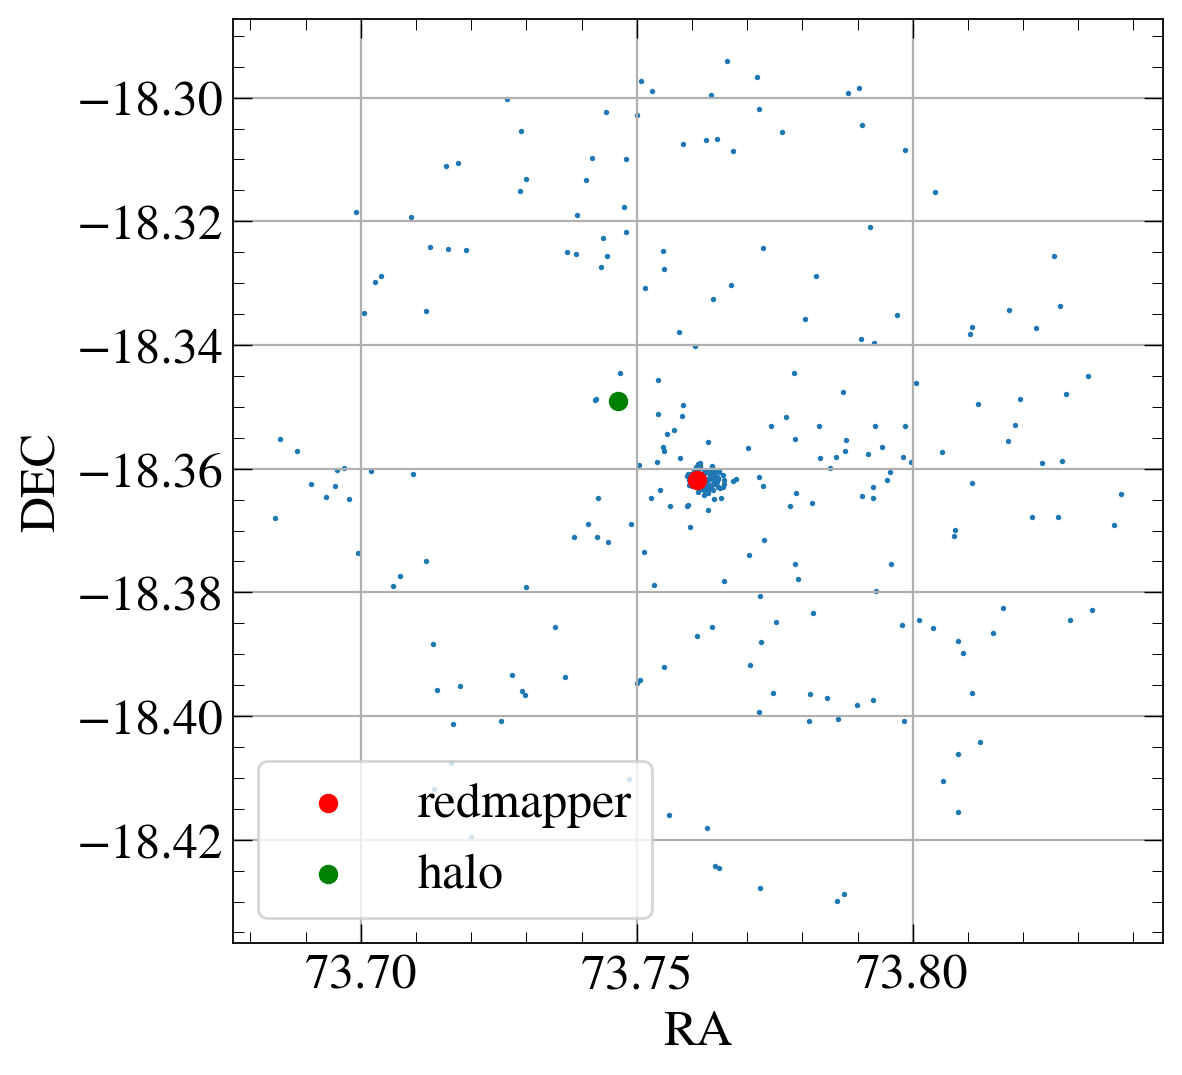

In [7]:
redmapper1 = redmapper[redmapper['mem_match_id']==25]
redmapper_me1 = redmapper_me[redmapper_me['mem_match_id']==25]
halos_redmapper1 = halos_redmapper[halos_redmapper['mem_match_id']==25]
plt.scatter(redmapper_me1['ra'],redmapper_me1['dec'], s=0.9)
plt.scatter(redmapper1['ra'],redmapper1['dec'], c='r', label='redmapper')
plt.scatter(halos_redmapper1['ra'],halos_redmapper1['dec'], c='g', label='halo') #- 360 * (halos_redmapper1['ra']>180)
# plt.scatter(halos_redmapper1['ra_cl'],halos_redmapper1['dec_cl'], c='k', label='halo')
plt.xlabel('RA')
plt.ylabel('DEC')
plt.legend()
plt.show()

In [57]:
# # max(redmapper_me.group_by('mem_match_id').groups, key=len)
# plt.scatter(halos_redmapper['ra'],halos_redmapper['dec'], alpha=0.5)
# plt.scatter(halos_redmapper['ra'],halos_redmapper['dec'], alpha=0.2)

## Method 2

We match clusters and halos using the first `id_cent` and `coadd_object_id` quantities respectively.

In [18]:
redmapper['id_cen0'] = [ids[0] for ids in redmapper['id_cent']]
redmapper['id_cen1'] = [ids[1] for ids in redmapper['id_cent']]
redmapper['id_cen2'] = [ids[2] for ids in redmapper['id_cent']]
redmapper['id_cen3'] = [ids[3] for ids in redmapper['id_cent']]
print(len(redmapper['id_cen0']))
print(sum(np.isin(halos['coadd_object_id'], redmapper['id_cen0'])))
print(sum(np.isin(halos['coadd_object_id'], redmapper['id_cen1'])))
print(sum(np.isin(halos['coadd_object_id'], redmapper['id_cen2'])))
print(sum(np.isin(halos['coadd_object_id'], redmapper['id_cen3'])))

redmapperM = Table(redmapper['mem_match_id','ra','dec','z','lambda','id_cen0','id_cen1','id_cen2','id_cen3'])
print(len(redmapperM))

15755
6954
3250
1940
1254
15755


In [16]:
redmapperM[:5]

mem_match_id,ra,dec,z,lambda,id_cen0,id_cen1,id_cen2,id_cen3
int32,float64,float64,float32,float32,int64,int64,int64,int64
8349,5.681395091912734,5.316021844546896,0.38282537,25.739355,345000877328,345000877688,345000877162,345000884121
30918,28.140282153877116,4.930398827783492,0.69005525,22.29173,357002535589,357002530770,357002530500,357002537780
174,33.56165613850777,4.965604697022471,0.5485525,97.773346,358002148421,358002148428,358002155682,358002148614
14921,33.6535503207799,5.179955697732865,0.5490896,22.429026,358002148859,358002153050,358002154236,358002149842
1089,3.224535701243405,3.5624060843837952,0.411461,36.08223,345001334124,345001339412,345001340495,345001337835


In [17]:
matched = Table(join(halos, redmapperM, keys_left='coadd_object_id', keys_right='id_cen3'))
matched.rename_columns(['ra_1','dec_1','ra_2','dec_2'], ['ra','dec','ra_cl','dec_cl'])
print(len(matched))
matched[:4]

1254


haloid,Mvir,Rvir,M200m,R200m,rho,DeltaSigma,Sigma,ra,dec,Redshift,pixel_id,comoving_dis,Angular_dis,coadd_object_id,mem_match_id,ra_cl,dec_cl,z,lambda,id_cen0,id_cen1,id_cen2,id_cen3
int64,float32,float64,float32,float64,float64[10],float64[15],float64[15],float32,float32,float64,int64,float64,float64,int64,int32,float64,float64,float32,float32,int64,int64,int64,int64
23334935,16570000000000.0,0.5928823826350329,17216440000000.0,0.637352,252695999499334.06 .. 302895248156.071,2.37520553565736e+25 .. 6.226361699586244e+23,4.0565291385652394e+25 .. 1.0012189983854114e+25,47.779243,-9.892886,0.41338,7249,1604.4038860392827,1135.1539473031191,4001795642,6398,47.75680479755012,-9.854406139305539,0.4404851,21.452707,4002836761,4001796182,4002837184,4001795642
23316504,10400000000000.0,0.5049664160401002,14942570000000.0,0.608723,1165262054935428.0 .. 7620084356407.461,-5.733448730368502e+25 .. 1.5336957725666794e+24,1.3094150204595291e+26 .. 1.222061252358617e+25,53.636562,-11.349517,0.424556,7251,1643.0855668130187,1153.4018787699597,4001796103,1301,53.62451363830398,-11.384385098535233,0.42103556,40.506172,4001795293,4001795511,4001801340,4001796103
23336032,14130000000000.0,0.571875193398659,14780150000000.0,0.605747,376434162021495.5 .. 147126972079.7185,-3.4429772206141357e+25 .. -2.9250755151500656e+23,1.305279168921109e+26 .. 8.999035748982678e+24,49.004074,-9.950627,0.387963,7121,1515.521546260224,1091.9034198031388,4001796306,12197,49.055665465635535,-9.94752298280308,0.38146782,21.330667,4001795240,4001801589,4001802782,4001796306
24191671,19160000000000.0,0.6061872257435396,19977560000000.0,0.669383,912165437926113.5 .. 2314796134430.7266,1.551824293088905e+25 .. 6.224693556476245e+23,9.547278655623056e+25 .. 1.2182726060551677e+25,48.191986,-9.567097,0.464406,7121,1779.0357070919943,1214.8514189999182,4002837168,10345,48.21346045789135,-9.60487910495732,0.49889758,20.17129,4002839027,4002837501,4002847929,4002837168


In [31]:
# np.save(filepath + 'halos_redmapper2_1254.npy',matched)  ## 44%
halos_redmapper2 = Table(np.load(filepath + "halos_redmapper2_6954.npy"))
print(len(halos_redmapper2))
halos_redmapper2[:5]

6954


haloid,Mvir,Rvir,M200m,R200m,rho,DeltaSigma,Sigma,ra,dec,Redshift,pixel_id,comoving_dis,Angular_dis,coadd_object_id,mem_match_id,ra_cl,dec_cl,z,lambda,id_cen0
int64,float32,float64,float32,float64,float64[10],float64[15],float64[15],float32,float32,float64,int64,float64,float64,int64,int32,float64,float64,float32,float32,int64
23316932,415600000000000.0,1695.729,0.0,0.0,0.0 .. 0.0,5.897457664204361e+25 .. 1.1633143152809224e+24,0.0 .. 0.0,53.511078,-13.181522,0.3394219852688456,7507,1342.236508721104,1002.1012970394789,4001795226,36,53.51107882064171,-13.181522139189028,0.34930596,129.09181,4001795226
23317308,336400000000000.0,1590.179,0.0,0.0,0.0 .. 0.0,1.6232939530599966e+26 .. 1.026799560711094e+23,0.0 .. 0.0,50.249798,-10.29826,0.37182434145096144,7250,1458.425707426717,1063.1286115568982,4001795227,421,50.24979888293102,-10.298259326894865,0.378286,46.501373,4001795227
23318268,195100000000000.0,1.363543266769073,206759700000000.0,1.45952,3711321600361529.0 .. 1453747765545.256,2.4442029471582594e+24 .. 1.8683860350074533e+24,6.411750069672793e+26 .. 1.0117269526998376e+25,53.48539,-11.462707,0.394159,7251,1537.3056435909161,1102.6759814274528,4001795228,2123,53.485390053581476,-11.462706781858088,0.4022858,31.154871,4001795228
23316537,405200000000000.0,1.7121203007518795,442429900000000.0,1.88069,4783135284456433.0 .. 5124064945073.053,3.784006408726895e+26 .. 1.0433252345693362e+24,2.835926364219564e+26 .. 1.2233274063993802e+25,53.739716,-11.414013,0.424205,7251,1641.8744149613685,1152.8357328905379,4001795231,687,53.739715607429595,-11.414012607867932,0.43014708,48.07264,4001795231
23317243,201400000000000.0,1340.924,0.0,0.0,0.0 .. 0.0,-4.138629062942915e+25 .. 1.0787350996349483e+24,0.0 .. 0.0,49.055664,-9.947523,0.3744272722006128,7121,1467.6691887166485,1067.8405605025175,4001795240,12197,49.055665465635535,-9.94752298280308,0.38146782,21.330667,4001795240


Text(0.5, 0, 'RA')

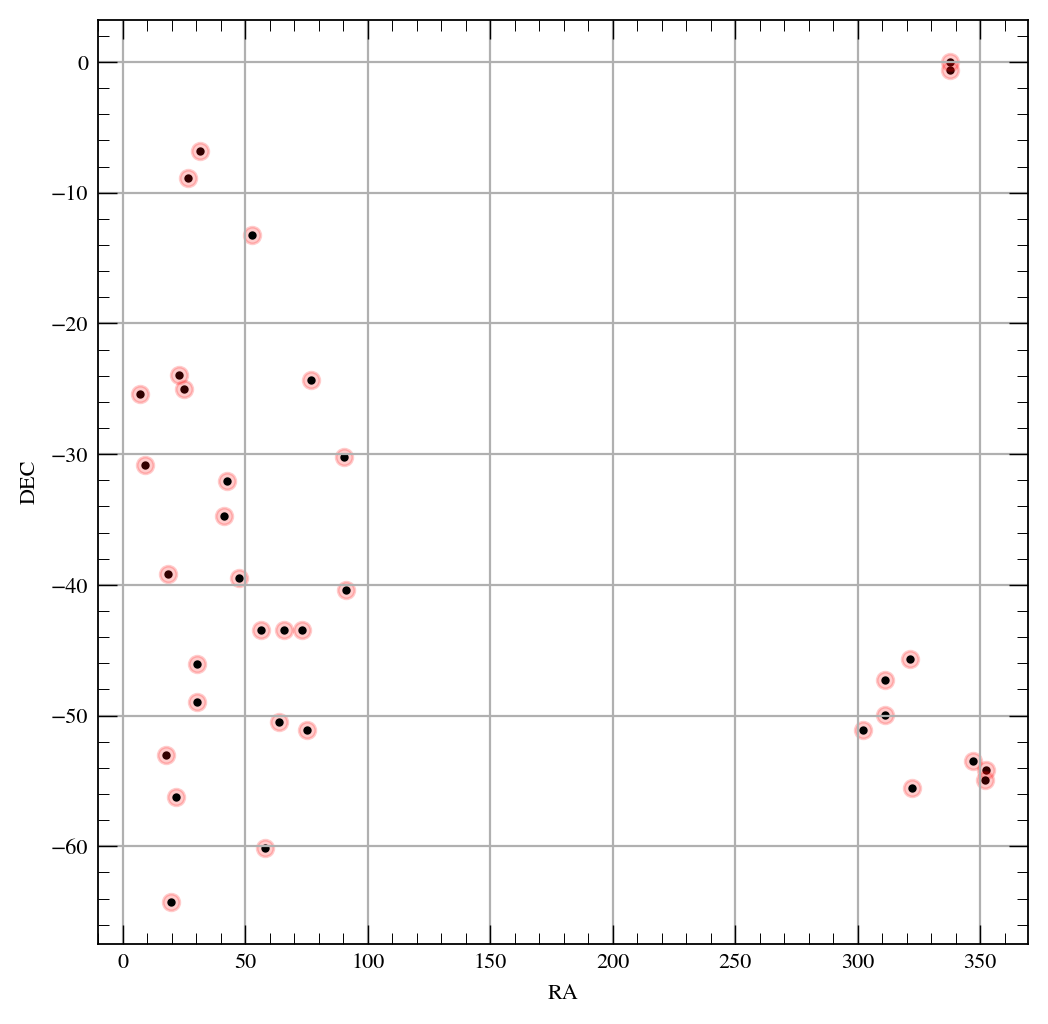

In [32]:
xx_h_r = halos_redmapper2[(halos_redmapper2['Mvir']<=2e13) & (halos_redmapper2['Redshift']<=0.35) & (halos_redmapper2['Redshift']<=0.5)][:500]
r = redmapper[np.isin(redmapper['mem_match_id'],xx_h_r['mem_match_id'] )]

for halo in range(len(xx_h_r)):
    plt.scatter(xx_h_r['ra'][halo],xx_h_r['dec'][halo], c='r',alpha=0.2)
    plt.scatter(r['ra'][halo],r['dec'][halo], c='k', s=4)
plt.ylabel('DEC')    
plt.xlabel('RA')

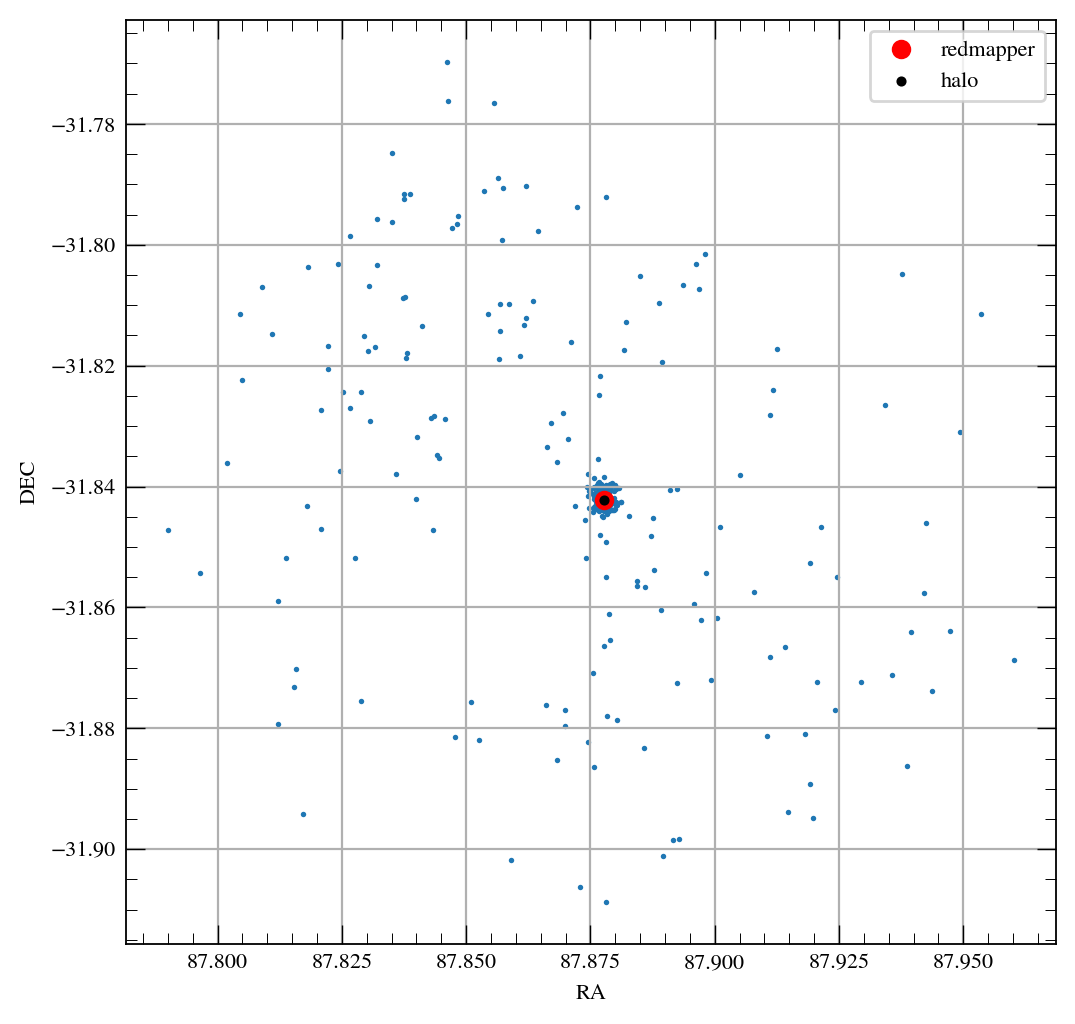

In [34]:
redmapper1 = redmapper[redmapper['mem_match_id']==3]
redmapper_me1 = redmapper_me[redmapper_me['mem_match_id']==3]
halos_redmapper1 = halos_redmapper2[halos_redmapper2['mem_match_id']==3]
plt.scatter(redmapper_me1['ra'],redmapper_me1['dec'], s=0.9)
plt.scatter(redmapper1['ra'],redmapper1['dec'], c='r', label='redmapper')
# plt.scatter(halos_redmapper1['ra'],halos_redmapper1['dec'], c='k', label='halo',s=100) #- 360 * (halos_redmapper1['ra']>180)
plt.scatter(halos_redmapper1['ra_cl'],halos_redmapper1['dec_cl'], c='k', label='halo',s=7)
plt.xlabel('RA')
plt.ylabel('DEC')
plt.legend()
plt.show()

In [56]:
# xx = redmapper_me.group_by('mem_match_id').groups.aggregate(len)
# xx[np.argsort(xx['id'])[::-1]]

Text(0, 0.5, 'Count')

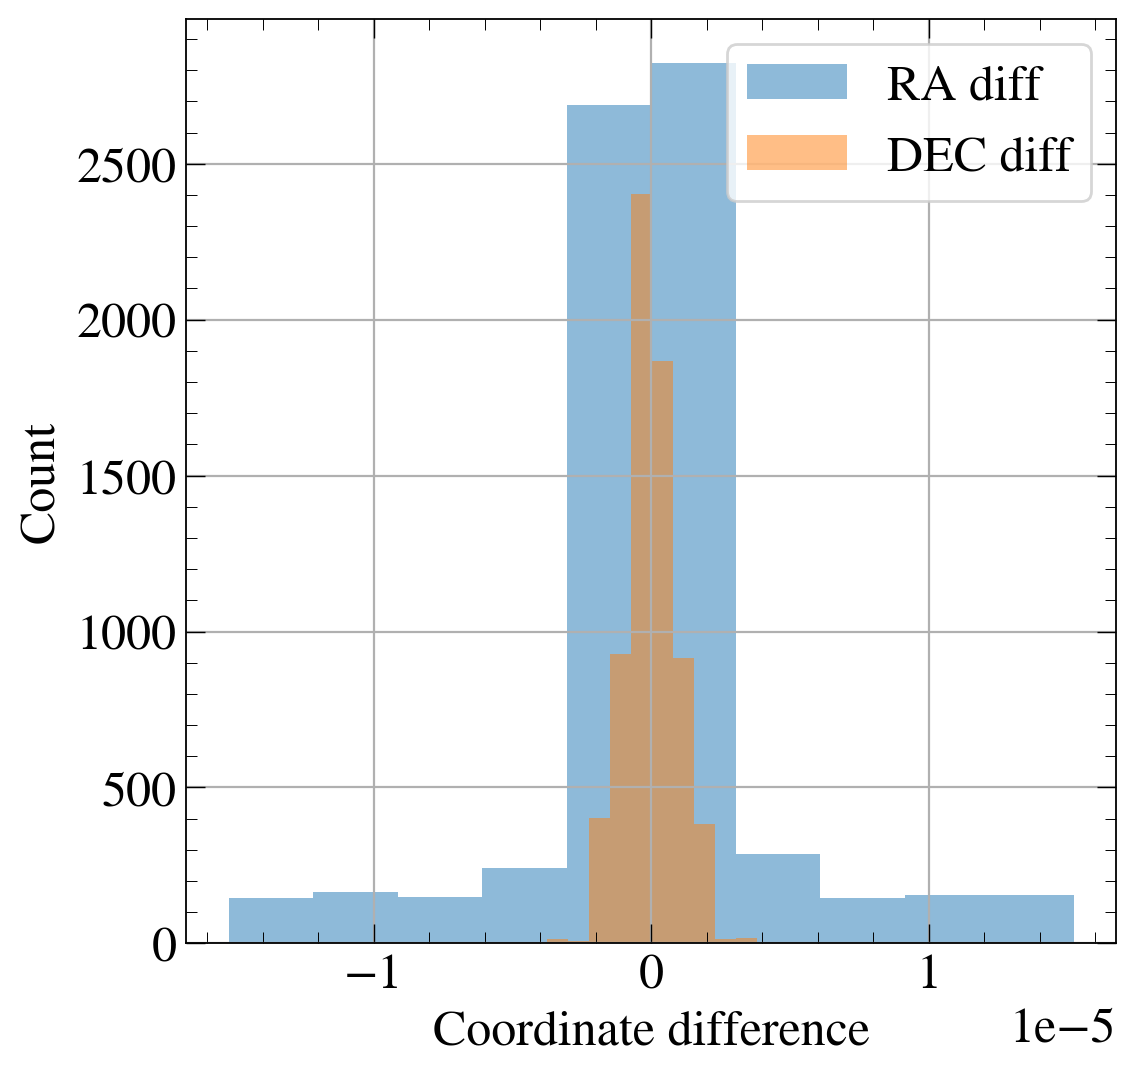

In [15]:
plt.hist(halos_redmapper2['ra'] - halos_redmapper2['ra_cl'], label='RA diff', alpha=0.5)
plt.hist(halos_redmapper2['dec'] - halos_redmapper2['dec_cl'], label='DEC diff', alpha=0.5)
plt.legend()
plt.xlabel('Coordinate difference')
plt.ylabel('Count')

## Method 3  (Shulei)

In [11]:
### Get the len of halos matching 1 single redmapper cluster entry and print out the results
red = redmapperM[:3]
# Assuming you have a list of selected_ids, one for each row in red
selected_ids_list = [
    np.array([red[f'id_cen{i}'][cids] for i in range(4)]) for cids in range(len(red))
]

for cids, selected_ids in enumerate(selected_ids_list):
    condition = np.isin(halos['coadd_object_id'], selected_ids)
    print(condition)
    filtered_halos = halos[condition]
    
    # Check if filtered_halos is not empty before printing
    if len(filtered_halos) > 0:
        print("Filtered Halos:")
        print(filtered_halos)
        
    # Print the corresponding row in red
    print("Corresponding Row in Red:")
    print(red[cids])
    print()


[False False False ... False False False]
Filtered Halos:
 haloid        Mvir       ...    Angular_dis     coadd_object_id
-------- ---------------- ... ------------------ ---------------
16961786 11860000000000.0 ... 1027.3306845542565    345000877688
17822571 72600000000000.0 ...   1106.84283606998    345000877162
17826398 34590000000000.0 ... 1109.1626121136098    345000877328
Corresponding Row in Red:
mem_match_id         ra               dec            z        lambda    id_cen0      id_cen1      id_cen2      id_cen3   
------------ ----------------- ----------------- ---------- --------- ------------ ------------ ------------ ------------
        8349 5.681395091912734 5.316021844546896 0.38282537 25.739355 345000877328 345000877688 345000877162 345000884121

[False False False ... False False False]
Corresponding Row in Red:
mem_match_id         ra                dec            z       lambda    id_cen0      id_cen1      id_cen2      id_cen3   
------------ ------------------ --

In [14]:
## Matching redmapper clusters with the most massive halo
red = redmapperM  # Replace with your red array
halos = halos  # Replace with your halos array

matched_red_with_halos = []

for cids, row in enumerate(red):
    selected_ids = np.array([row[f'id_cen{i}'] for i in range(4)])  # Extract IDs from the current row
    
    # Filter halos based on selected IDs
    condition = np.isin(halos['coadd_object_id'], selected_ids)
    filtered_halos = halos[condition]
    
    # Find the halo with maximum Mvir
    if len(filtered_halos) > 0:
        max_mvir_halo = filtered_halos[np.argmax(filtered_halos['M200m'])]
        matched_row = {**max_mvir_halo, **row}
        matched_red_with_halos.append(matched_row)

# matched_red_with_halos will contain the combined rows from red and the matching halos

In [15]:
matched_red_with_halos = Table(matched_red_with_halos)
len(matched_red_with_halos)
# np.save(filepath + 'halos_redmapper3_8420_1.npy',matched_red_with_halos) 

## Binning with redshift and richness

In [17]:
halos2['Redshift'].min(),halos2['Redshift'].max(), redmapper['z'].min(),redmapper['z'].max()

(0.180005, 0.659999, 0.10528861, 0.94225204)

In [18]:
zranges = [(0.2,0.35), (0.35, 0.5), (0.5, 0.65), (0.65, 0.8)] #, 
lamranges = [(20,30), (30,45), (45,60), (60,500)]
zlabels = ['(0.2,0.35]', '(0.35, 0.5]', '(0.5, 0.65]', '(0.65, 0.8]'] #, '(0.8,0.95]'
lamlabels = ['(20,30]', '(30,45]', '(45,60]', '(60,500]']
match2['redshift_range'] = pd.cut(match2['Redshift'], bins=[r[0] for r in zranges] + [zranges[-1][-1]], labels=zlabels)
match2['lambda_range'] = pd.cut(match2['lambda'], bins=[r[0] for r in lamranges] + [lamranges[-1][-1]], labels=lamlabels)


halos2['redshift_range'] = pd.cut(halos2['Redshift'], bins=[r[0] for r in zranges] + [zranges[-1][-1]], labels=zlabels)
print(len(halos2), len(match2))

648278 10190


In [19]:
halos2['redshift_range'] = halos2['redshift_range'].astype(str)
halos2 = halos2[(halos2['redshift_range']!='nan')]

match2['redshift_range'] = match2['redshift_range'].astype(str)
match2 = match2[(match2['redshift_range']!='nan')]
print(len(halos2), len(match2))

640254 10157


# Quantify the Selection Bias

In [57]:
## Weighted Profile
def stacked_profile_weighted_by_mass_redshift(lnM_select, z_select, prof_select, lnM_all, z_all, profile_A, dm=0.1, dz=0.05):
    #### set up the bins for mass and redshift  (sigma_select/profile_select, sigma_all/profile_all)
    min_m = min(lnM_select)#-dm
    max_m = max(lnM_select)#+dm
    min_z = min(z_select)#-dz
    max_z = max(z_select)#+dz

    m_bins = np.arange(min_m, max_m+dm, dm)
    z_bins = np.arange(min_z, max_z+dz, dz)
    nM = len(m_bins)-1
    nz = len(z_bins)-1

    profile_select = np.array([i.tolist() for i in prof_select])
    profile_all = np.array([i.tolist() for i in profile_A])

    nr = np.shape(profile_select)[1]#rbp.nbins_phys_mpc...1
    profile_weighted = np.zeros(nr)
    weight_norm = 0
    err_weighted = np.zeros(nr)

    pdf1_list = np.zeros([nz, nM]) # see how many bins are too narrow
    pdf2_list = np.zeros([nz, nM]) # see how many bins are too narrow

    for iz in range(nz):
        z_lo = z_bins[iz]
        z_hi = z_bins[iz+1]
        for iM in range(nM):
            m_lo = m_bins[iM]
            m_hi = m_bins[iM+1]
            
            select_bin = (lnM_select >= m_lo)&(lnM_select < m_hi)&(z_select>=z_lo)&(z_select<z_hi)
            weight = len(lnM_select[select_bin]) * 1.
            weight_norm += weight
            select_all = (lnM_all >= m_lo)&(lnM_all < m_hi)&(z_all>=z_lo)&(z_all<z_hi)

            pdf1_list[iz, iM] = weight
            pdf2_list[iz, iM] = len(lnM_all[select_all])

            if weight > 0 and len(lnM_all[select_all]) > 0:
                profile_weighted += (np.mean(profile_all[select_all, :], axis=0)*weight) #0
    profile_weighted /= weight_norm

    pdf1_list = np.concatenate(pdf1_list)
    pdf2_list = np.concatenate(pdf2_list)
    diff_list = pdf2_list - pdf1_list

    return profile_weighted


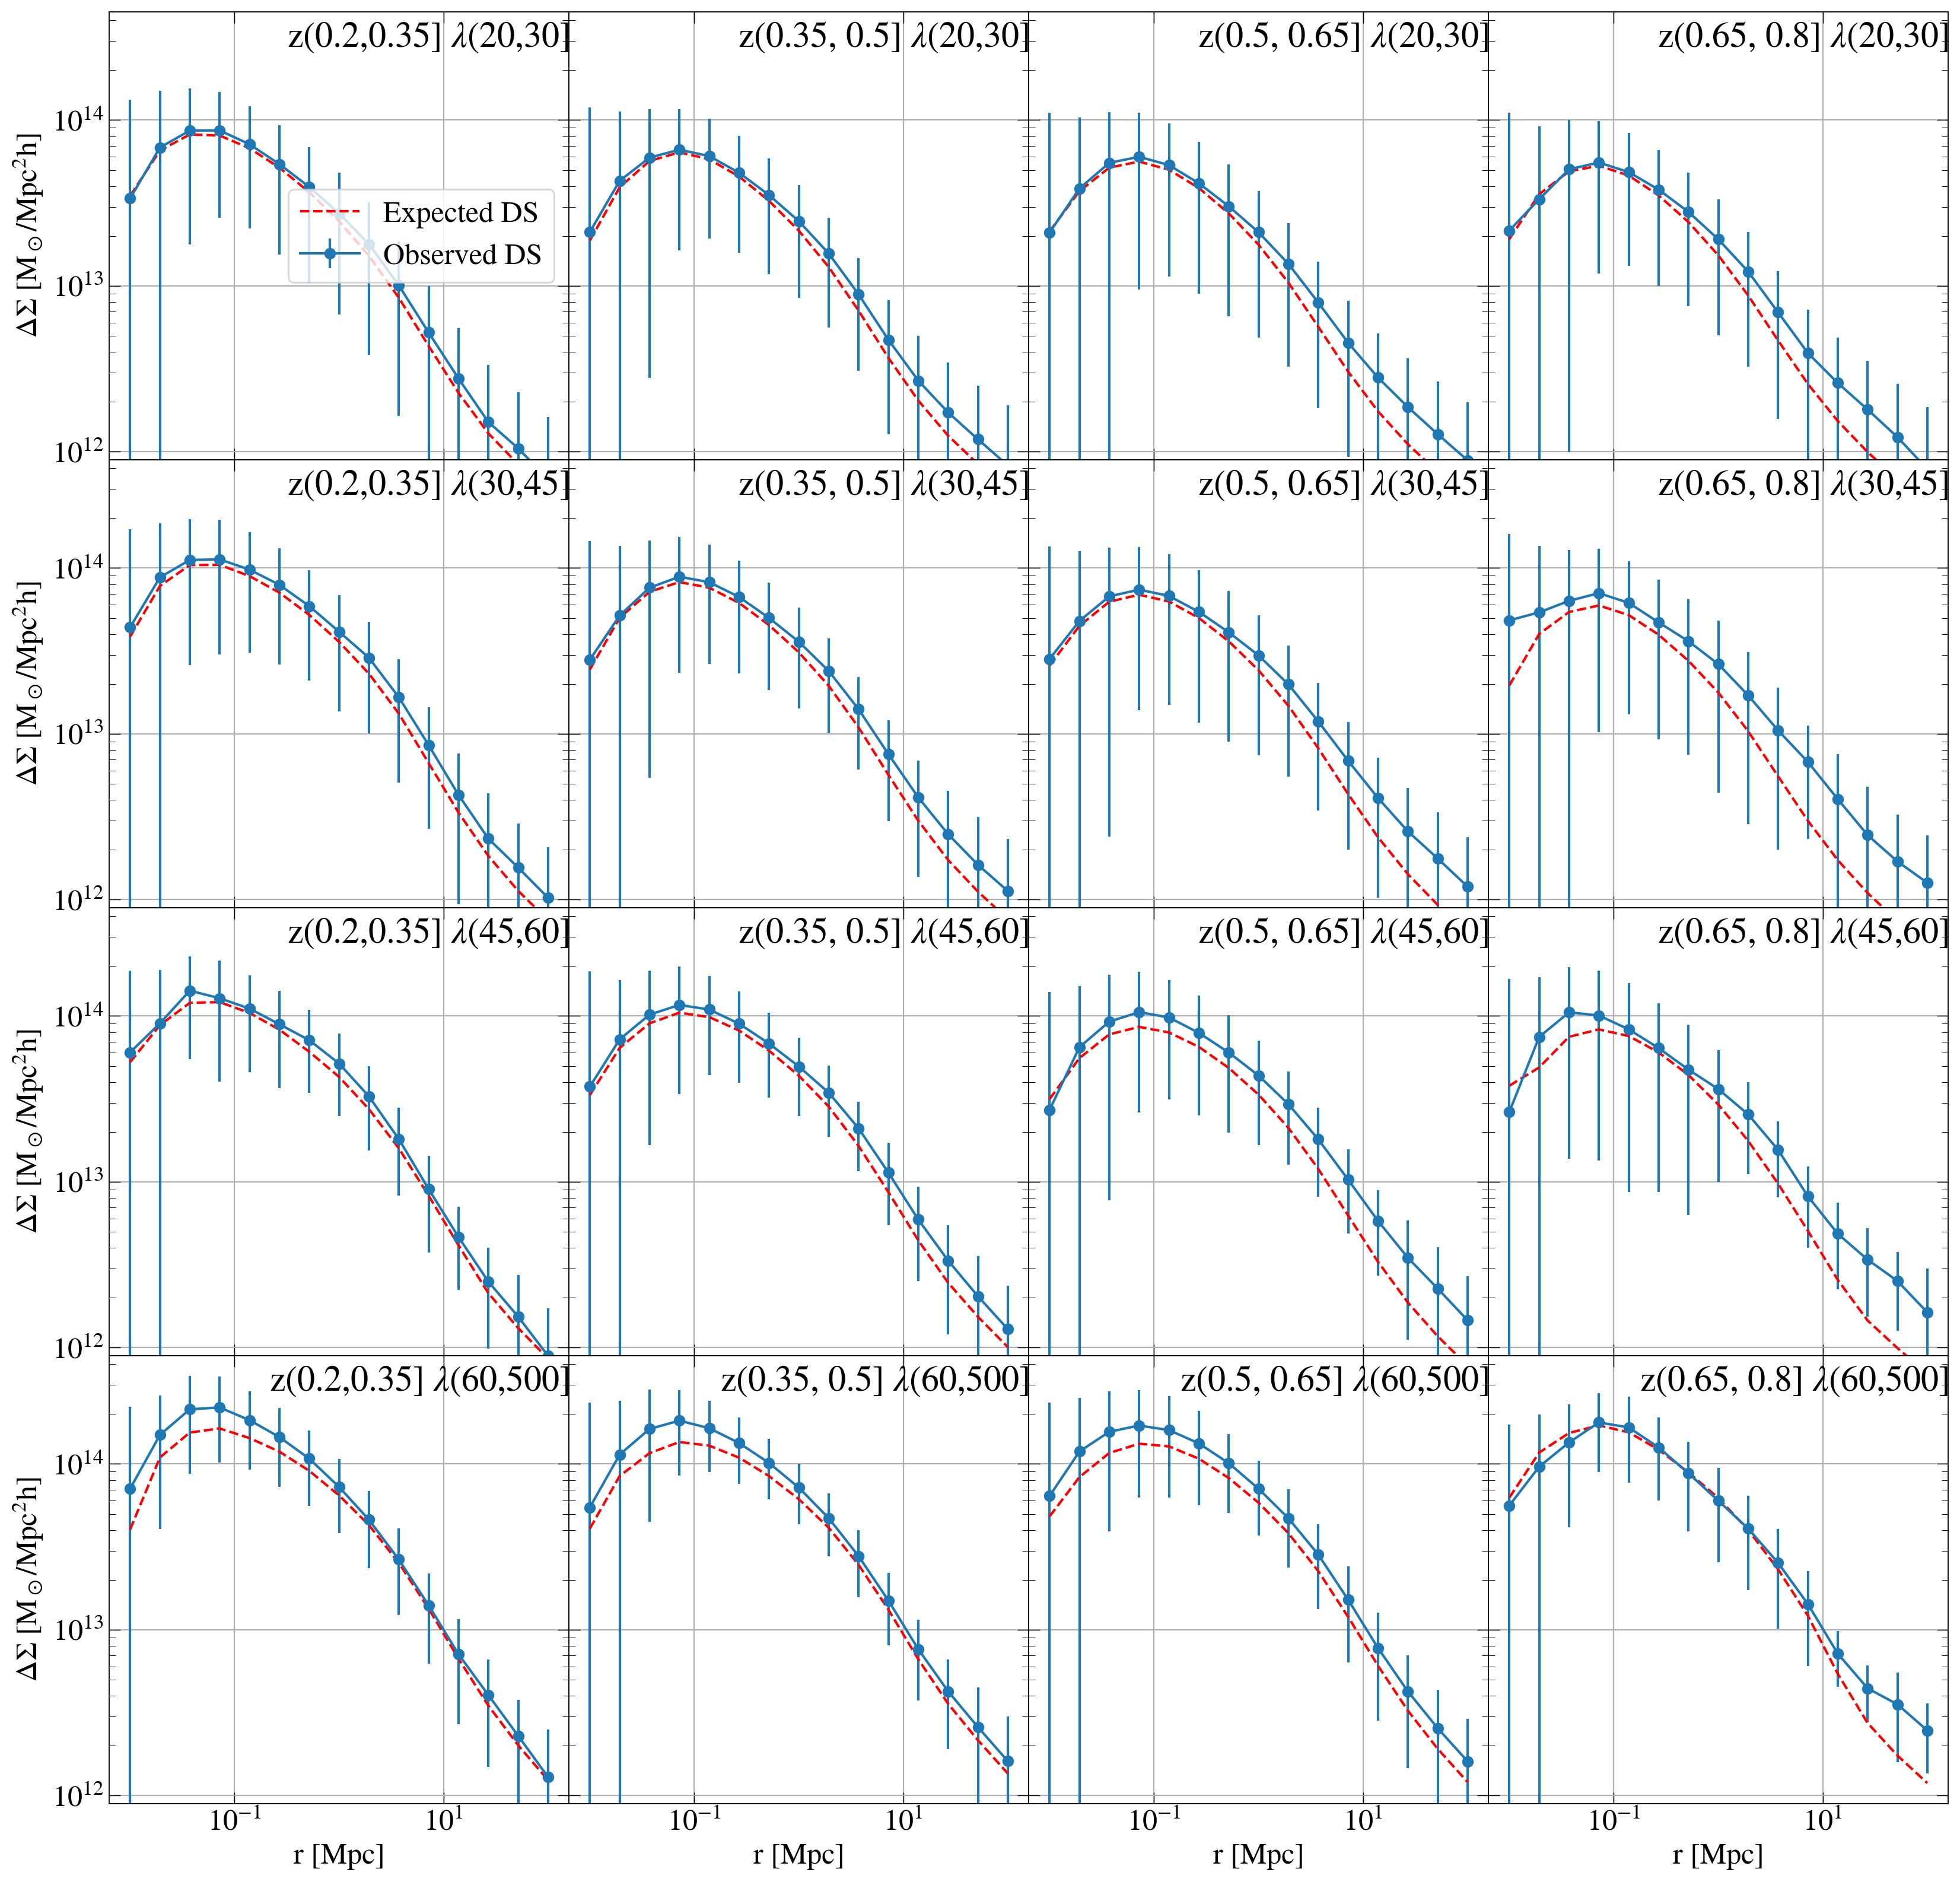

In [58]:
grouped_halos = halos2.group_by('redshift_range')
grouped_cl_halos = match2.group_by(['redshift_range','lambda_range'])

# Get unique redshift groups
redshift_groups = sorted(np.unique(match2['redshift_range']))

# Create a figure with subplots
fig, axes = plt.subplots(4, len(redshift_groups), figsize=(20, 20), sharex=True, sharey=True)

for Cl_H in grouped_cl_halos.groups:  # matched clusters and halos
    for H in grouped_halos.groups:  # Underlying halos
        if Cl_H['redshift_range'][0] == H['redshift_range'][0]:
            lnM_sel = np.log10(Cl_H['Mvir'])
            z_sel = Cl_H['Redshift']
            profile_sel = Cl_H['Sigma']
            profile_sel_ds = Cl_H['DeltaSigma']

            lnM_All = np.log10(H['Mvir'])
            z_All = H['Redshift']
            profile_All = H['Sigma']
            profile_All_ds = H['DeltaSigma']
            
            expected_ds = stacked_profile_weighted_by_mass_redshift(lnM_sel, z_sel, profile_sel_ds, lnM_All, z_All, profile_All_ds, dm=0.1, dz=0.05)

            # Extract numerical values from redshift and lambda group labels
            redshift_value = float(re.findall(r'\d+\.\d+', Cl_H['redshift_range'][0])[0])
            lambda_value = float(re.findall(r'\d+', Cl_H['lambda_range'][0])[0])

            # Calculate the row and column indices for the subplot
            row_index = int(lambda_value) // 15 - 1
            col_index = redshift_groups.index(Cl_H['redshift_range'][0])

            err_ds = np.array(Cl_H['DeltaSigma']).std(axis=0)
            axes[row_index, col_index].plot(bins, expected_ds, label='Expected DS', linestyle='--', c='r')
            axes[row_index, col_index].errorbar(bins, Cl_H['DeltaSigma'].mean(axis=0) ,err_ds, marker='o', label='Observed DS')
             # Set xscale and yscale to log
            axes[row_index, col_index].set_xscale('log')
            axes[row_index, col_index].set_yscale('log')

            axes[0, 0].legend(loc='center right')

            # Set the title inside the subplot
            ztitle = Cl_H['redshift_range'][0]
            lamtitle = Cl_H['lambda_range'][0]
            title = f'z{ztitle} $\lambda${lamtitle}'
            title_y = 1.1 if row_index > 3 else 0.9  # Adjust the y position for the last row
            axes[row_index, col_index].set_title(title,  loc='right', y=title_y)


# Adjust the spacing between subplots
plt.subplots_adjust(hspace=0, wspace=0)

# Share y-axis across all subplots
for ax in axes.flat:
    ax.label_outer()

# Set the x and y-axis labels for the bottom subplots
for ax in axes[-1, :]:
    ax.set_xlabel('r [Mpc]')
for ax in axes[:, 0]:
    ax.set_ylabel('$\Delta\Sigma ~[\mathrm{M}_\odot/\mathrm{Mpc}^2 \mathrm{h}]$')

# plt.legend()
# plt.savefig('Images/DSCardinal.png', facecolor='white')
plt.show()

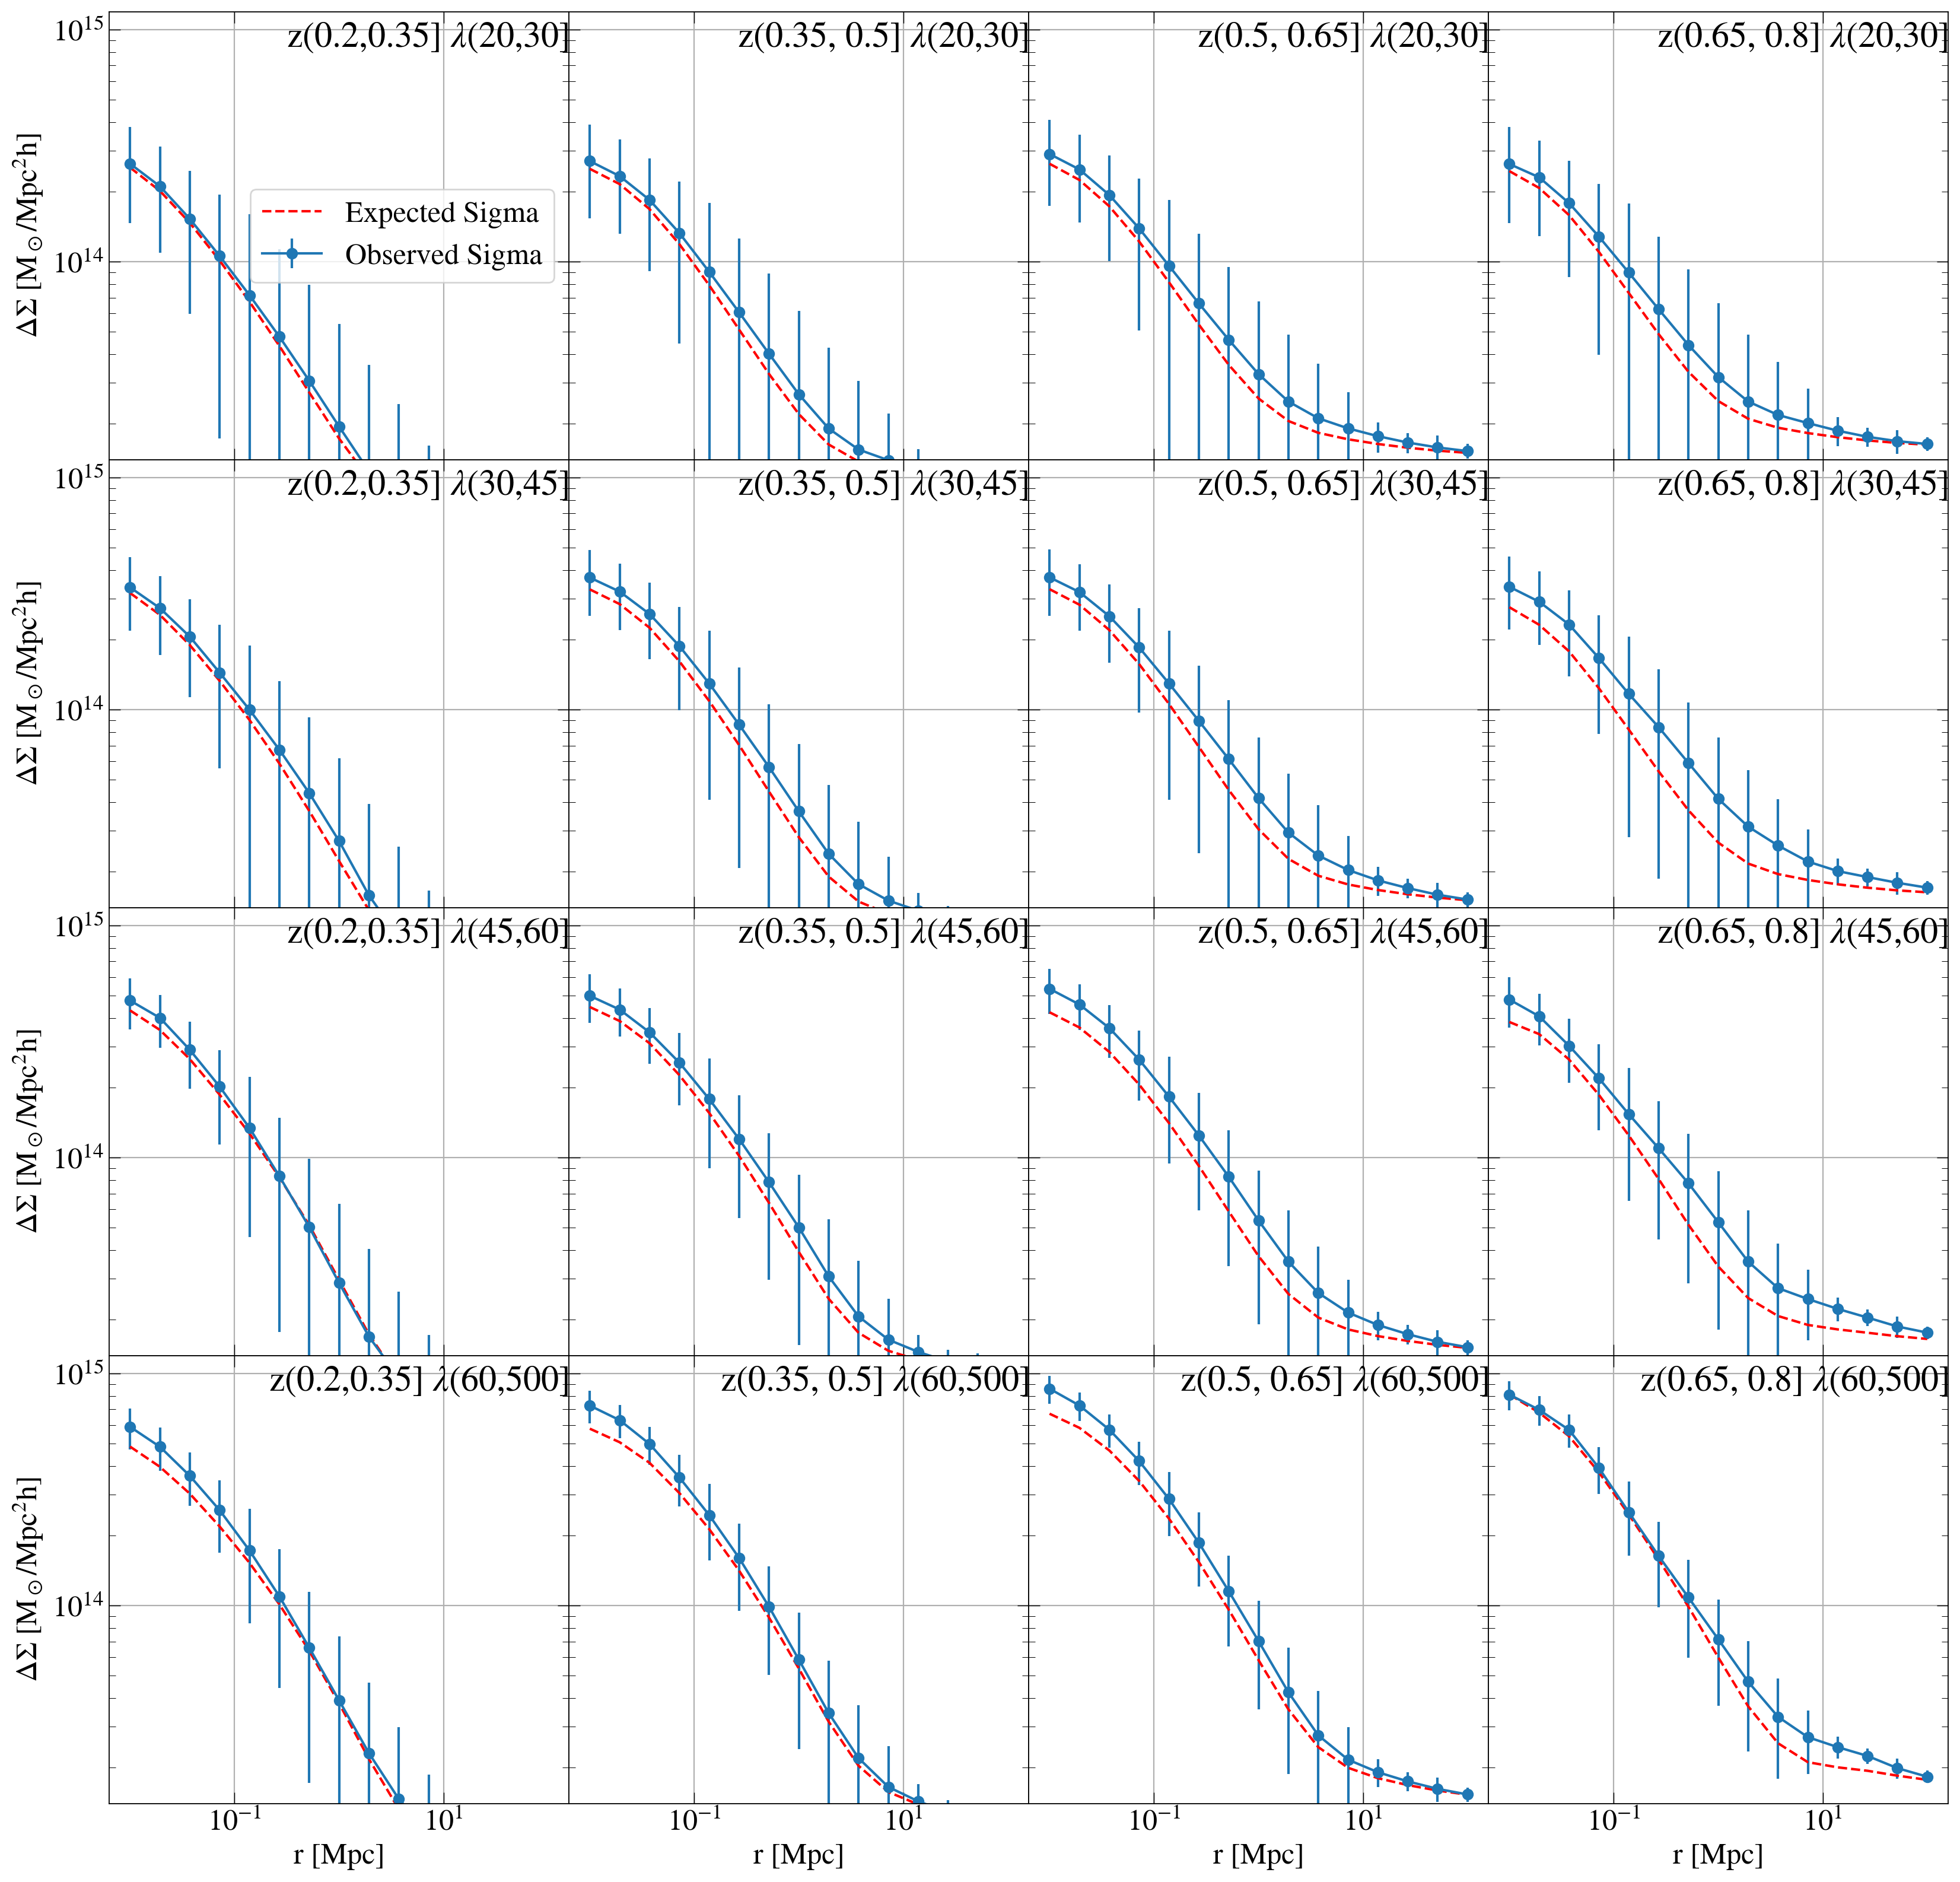

In [59]:
# Create a figure with subplots
fig, axes = plt.subplots(4, len(redshift_groups), figsize=(20, 20), sharex=True, sharey=True)

for Cl_H in grouped_cl_halos.groups:  # matched clusters and halos
    for H in grouped_halos.groups:  # Underlying halos
        if Cl_H['redshift_range'][0] == H['redshift_range'][0]:
            lnM_sel = np.log10(Cl_H['Mvir'])
            z_sel = Cl_H['Redshift']
            profile_sel = Cl_H['Sigma']
            profile_sel_ds = Cl_H['DeltaSigma']

            lnM_All = np.log10(H['Mvir'])
            z_All = H['Redshift']
            profile_All = H['Sigma']
            profile_All_ds = H['DeltaSigma']
    
            expected_sigma = stacked_profile_weighted_by_mass_redshift(lnM_sel, z_sel, profile_sel, lnM_All, z_All, profile_All, dm=0.1, dz=0.05)

            # Extract numerical values from redshift and lambda group labels
            redshift_value = float(re.findall(r'\d+\.\d+', Cl_H['redshift_range'][0])[0])
            lambda_value = float(re.findall(r'\d+', Cl_H['lambda_range'][0])[0])

            # Calculate the row and column indices for the subplot
            row_index = int(lambda_value) // 15 - 1
            col_index = redshift_groups.index(Cl_H['redshift_range'][0])

            axes[row_index, col_index].plot(bins, expected_sigma, label='Sigma', linestyle='--', c='r')
            axes[row_index, col_index].errorbar(bins, Cl_H['Sigma'].mean(axis=0) ,err_ds, marker='o', label='Observed Sigma')
             # Set xscale and yscale to log
            axes[row_index, col_index].set_xscale('log')
            axes[row_index, col_index].set_yscale('log')

            axes[0, 0].legend(loc='center right')

            # Set the title inside the subplot
            ztitle = Cl_H['redshift_range'][0]
            lamtitle = Cl_H['lambda_range'][0]
            title = f'z{ztitle} $\lambda${lamtitle}'
            title_y = 1.1 if row_index > 3 else 0.9  # Adjust the y position for the last row
            axes[row_index, col_index].set_title(title,  loc='right', y=title_y)


# Adjust the spacing between subplots
plt.subplots_adjust(hspace=0, wspace=0)

# Share y-axis across all subplots
for ax in axes.flat:
    ax.label_outer()

# Set the x and y-axis labels for the bottom subplots
for ax in axes[-1, :]:
    ax.set_xlabel('r [Mpc]')
for ax in axes[:, 0]:
    ax.set_ylabel('$\Sigma ~[\mathrm{M}_\odot/\mathrm{Mpc}^2 \mathrm{h}]$')

# plt.legend()
# plt.savefig('Images/SigmaCardinal.png', facecolor='white')
plt.show()

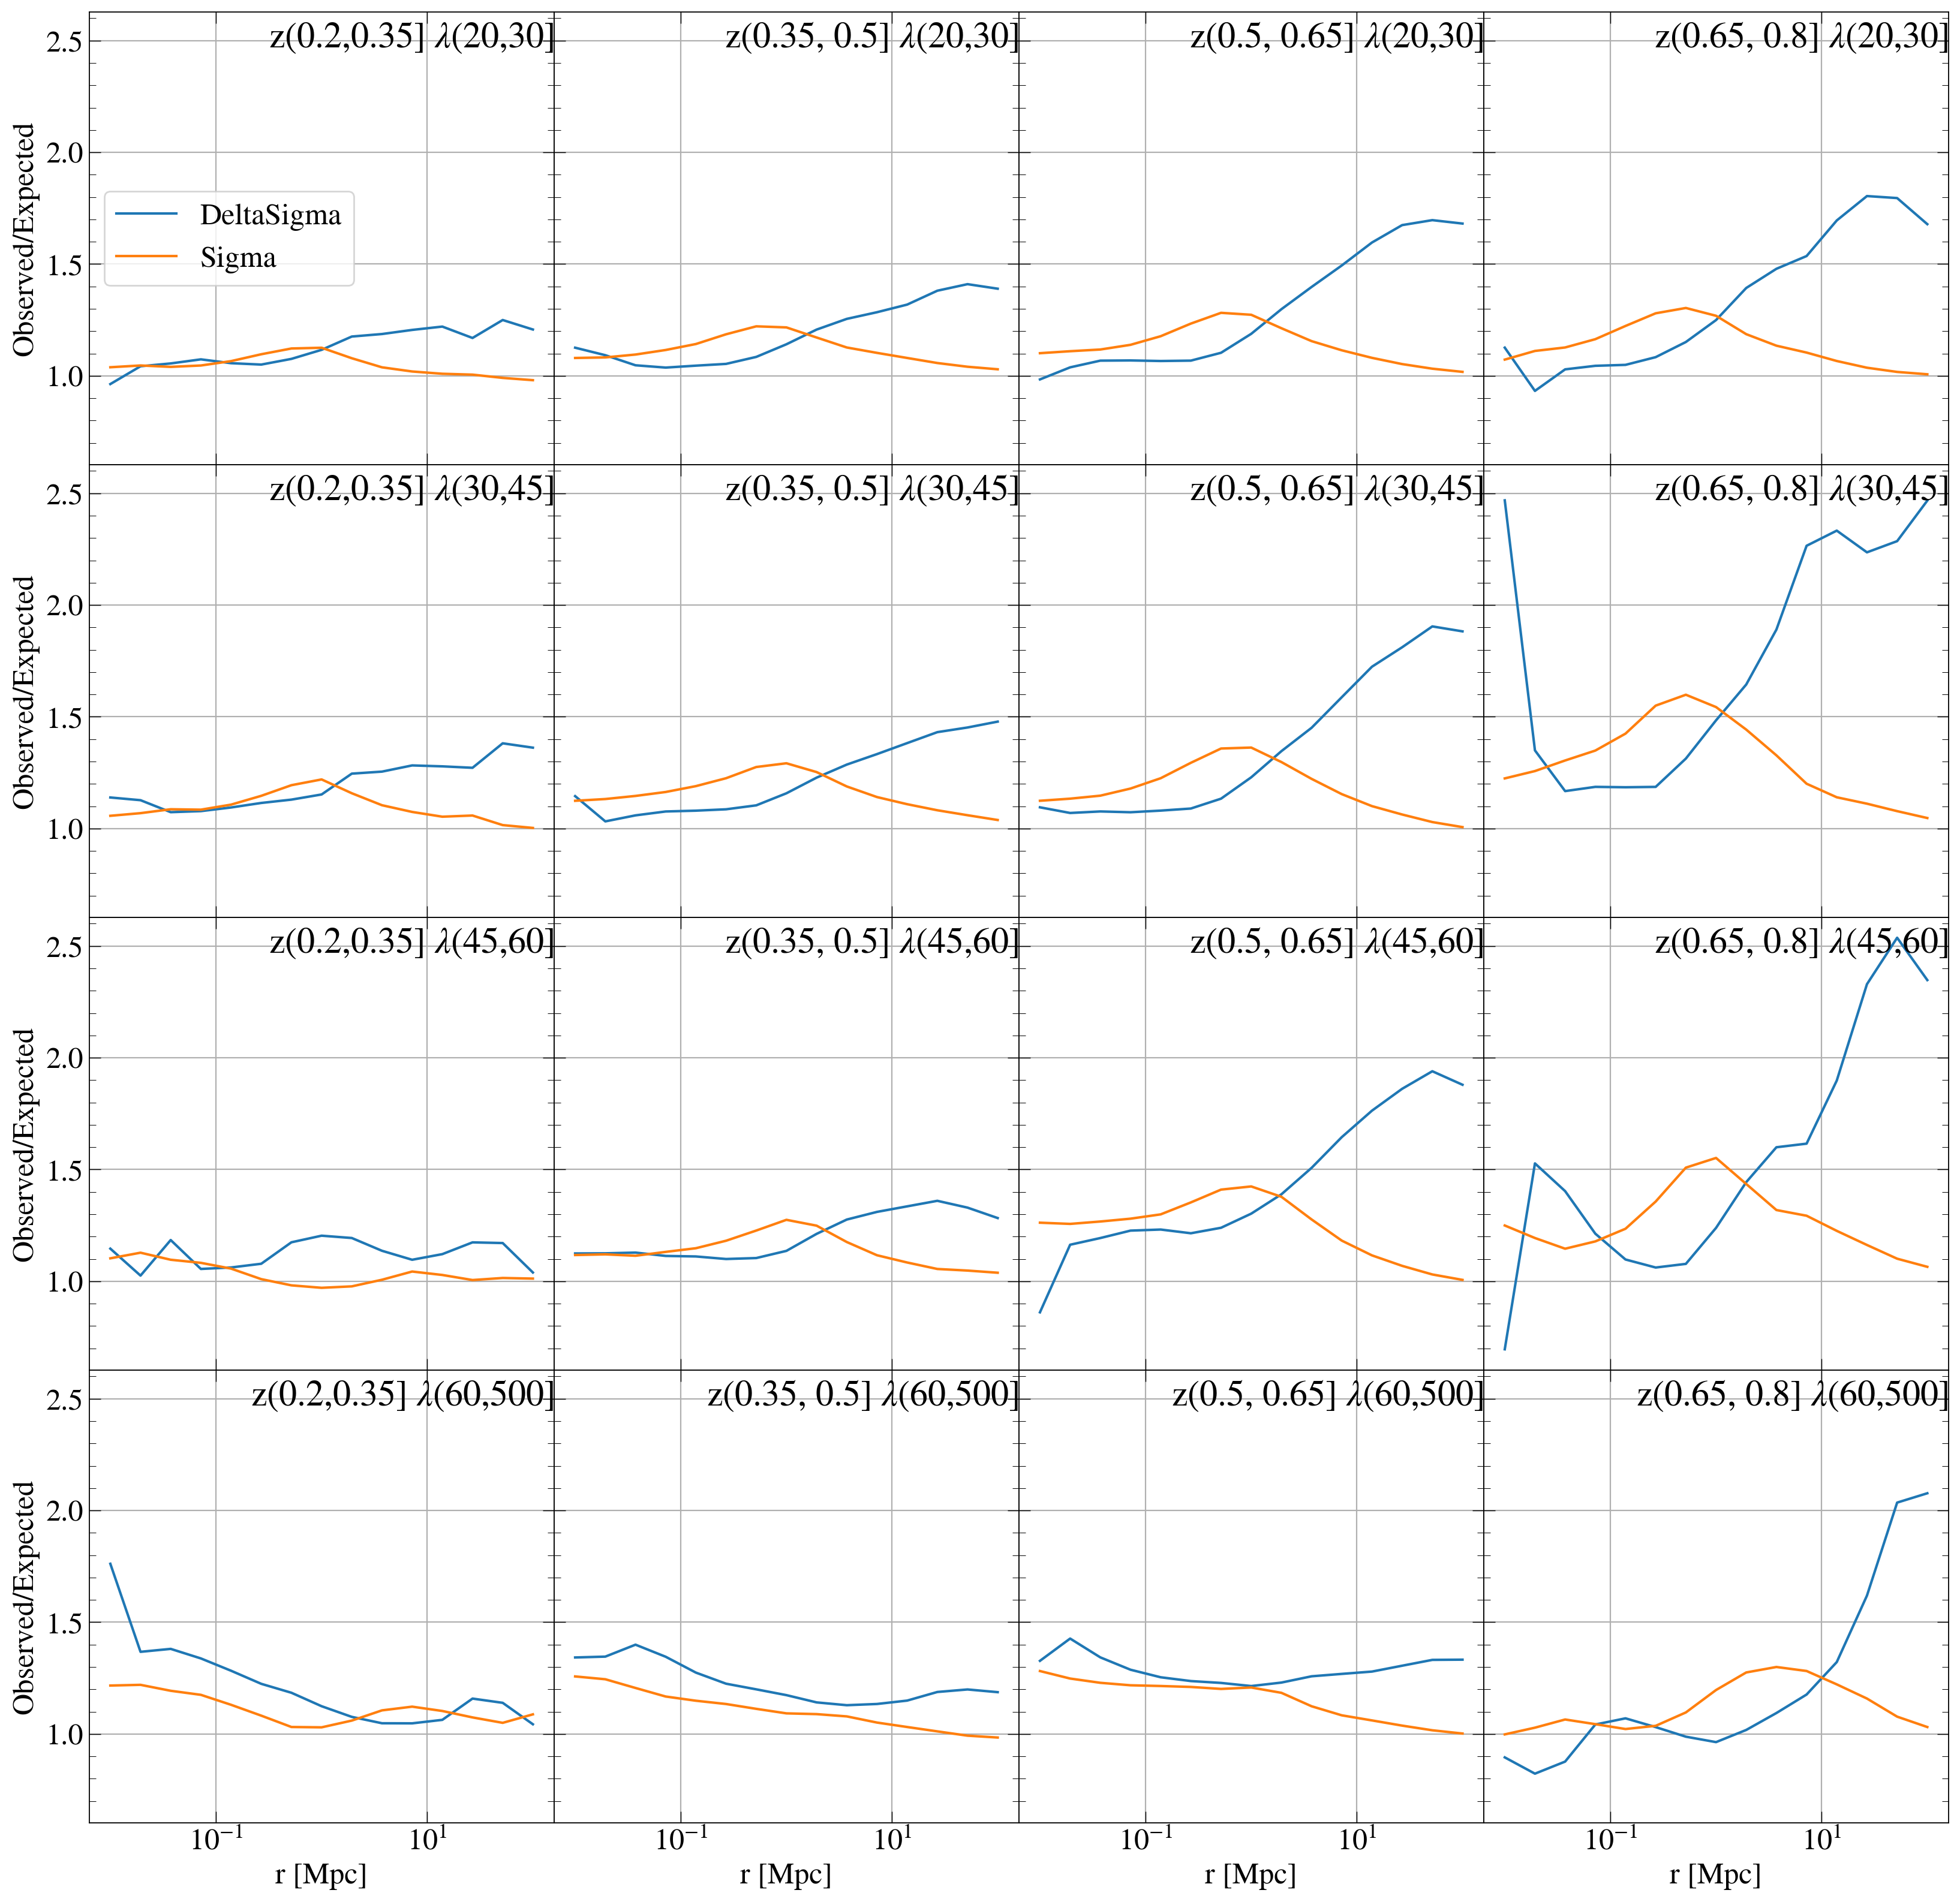

In [60]:
# Create a figure with subplots   ### Cardinal is in comoving
fig, axes = plt.subplots(4, len(redshift_groups), figsize=(20, 20), sharex=True, sharey=True)

for Cl_H in grouped_cl_halos.groups:  # matched clusters and halos
    for H in grouped_halos.groups:  # Underlying halos
        if Cl_H['redshift_range'][0] == H['redshift_range'][0]:
            lnM_sel = np.log10(Cl_H['Mvir'])
            z_sel = Cl_H['Redshift']
            profile_sel = Cl_H['Sigma']
            profile_sel_ds = Cl_H['DeltaSigma']

            lnM_All = np.log10(H['Mvir'])
            z_All = H['Redshift']
            profile_All = H['Sigma']
            profile_All_ds = H['DeltaSigma']
    
            expected_sigma = stacked_profile_weighted_by_mass_redshift(lnM_sel, z_sel, profile_sel, lnM_All, z_All, profile_All, dm=0.1, dz=0.05)
            expected_ds = stacked_profile_weighted_by_mass_redshift(lnM_sel, z_sel, profile_sel_ds, lnM_All, z_All, profile_All_ds, dm=0.1, dz=0.05)

            # Extract numerical values from redshift and lambda group labels
            redshift_value = float(re.findall(r'\d+\.\d+', Cl_H['redshift_range'][0])[0])
            lambda_value = float(re.findall(r'\d+', Cl_H['lambda_range'][0])[0])

            # Calculate the row and column indices for the subplot
            row_index = int(lambda_value) // 15 - 1
            col_index = redshift_groups.index(Cl_H['redshift_range'][0])

            # Plot the lensing signal in the corresponding subplot
            ratio_ds = np.array(Cl_H['DeltaSigma'].mean(axis=0))/np.array(expected_ds)
            ratio_sigma = np.array(Cl_H['Sigma'].mean(axis=0))/np.array(expected_sigma)

            axes[row_index, col_index].plot(bins, ratio_ds, label='DeltaSigma')
            axes[row_index, col_index].plot(bins, ratio_sigma, label='Sigma')
    
             # Set xscale and yscale to log
            axes[row_index, col_index].set_xscale('log')
            axes[0, 0].legend(loc='center left')

            # Set the title inside the subplot
            ztitle = Cl_H['redshift_range'][0]
            lamtitle = Cl_H['lambda_range'][0]
            title = f'z{ztitle} $\lambda${lamtitle}'
            title_y = 1.1 if row_index > 3 else 0.9  # Adjust the y position for the last row
            axes[row_index, col_index].set_title(title,  loc='right', y=title_y)


# Adjust the spacing between subplots
plt.subplots_adjust(hspace=0, wspace=0)

# Share y-axis across all subplots
for ax in axes.flat:
    ax.label_outer()

# Set the x and y-axis labels for the bottom subplots
for ax in axes[-1, :]:
    ax.set_xlabel('r [Mpc]')
for ax in axes[:, 0]:
    ax.set_ylabel('Observed/Expected')

# plt.legend()
# plt.savefig('Images/SBiasCardinal.png', facecolor='white')
plt.show()

## Selection Bias comparison with Buzzard

In [61]:
zranges = [(0.2,0.35), (0.35, 0.5), (0.5, 0.65)] #, 
lamranges = [(20,30), (30,45), (45,60), (60,500)]
zlabels = ['(0.2,0.35]', '(0.35, 0.5]', '(0.5, 0.65]'] #, '(0.8,0.95]'
lamlabels = ['(20,30]', '(30,45]', '(45,60]', '(60,500]']
match2['redshift_range'] = pd.cut(match2['Redshift'], bins=[r[0] for r in zranges] + [zranges[-1][-1]], labels=zlabels)
match2['lambda_range'] = pd.cut(match2['lambda'], bins=[r[0] for r in lamranges] + [lamranges[-1][-1]], labels=lamlabels)


halos2['redshift_range'] = pd.cut(halos2['Redshift'], bins=[r[0] for r in zranges] + [zranges[-1][-1]], labels=zlabels)
print(len(halos2), len(match2))

halos2['redshift_range'] = halos2['redshift_range'].astype(str)
halos2 = halos2[(halos2['redshift_range']!='nan')]

match2['redshift_range'] = match2['redshift_range'].astype(str)
match2 = match2[(match2['redshift_range']!='nan')]
print(len(halos2), len(match2))

640254 10157
618215 9664


In [62]:
all_filenames = [i for i in glob(file_path + '/Data_Buzzard/DeltaSigma_combine_version_z_*.dat'.format('ascii'))]
print(len(all_filenames))
buzzard_ds = vstack([Table.read(f, format='ascii') for f in all_filenames])
buzzard_ds.rename_columns(['col1','col2','col3'],['r','ds_ratio','err'])
buzzard_ds['redshift_range'] = np.repeat(zlabels, 60)
buzzard_ds['lambda_range'] = list(np.repeat(lamlabels,15))*3
print(len(buzzard_ds))
buzzard_ds[:20]

12
180


r,ds_ratio,err,redshift_range,lambda_range
float64,float64,float64,str11,str8
0.0405633,1.05647,0.13615,"(0.2,0.35]","(20,30]"
0.0639727,1.05314,0.0454602,"(0.2,0.35]","(20,30]"
0.100892,1.05421,0.0268318,"(0.2,0.35]","(20,30]"
0.159117,1.04659,0.0217148,"(0.2,0.35]","(20,30]"
0.250945,1.04463,0.0167534,"(0.2,0.35]","(20,30]"
0.395767,1.04809,0.0150392,"(0.2,0.35]","(20,30]"
0.624167,1.06478,0.0120481,"(0.2,0.35]","(20,30]"
0.984378,1.09624,0.0125524,"(0.2,0.35]","(20,30]"
1.55247,1.12898,0.0197559,"(0.2,0.35]","(20,30]"


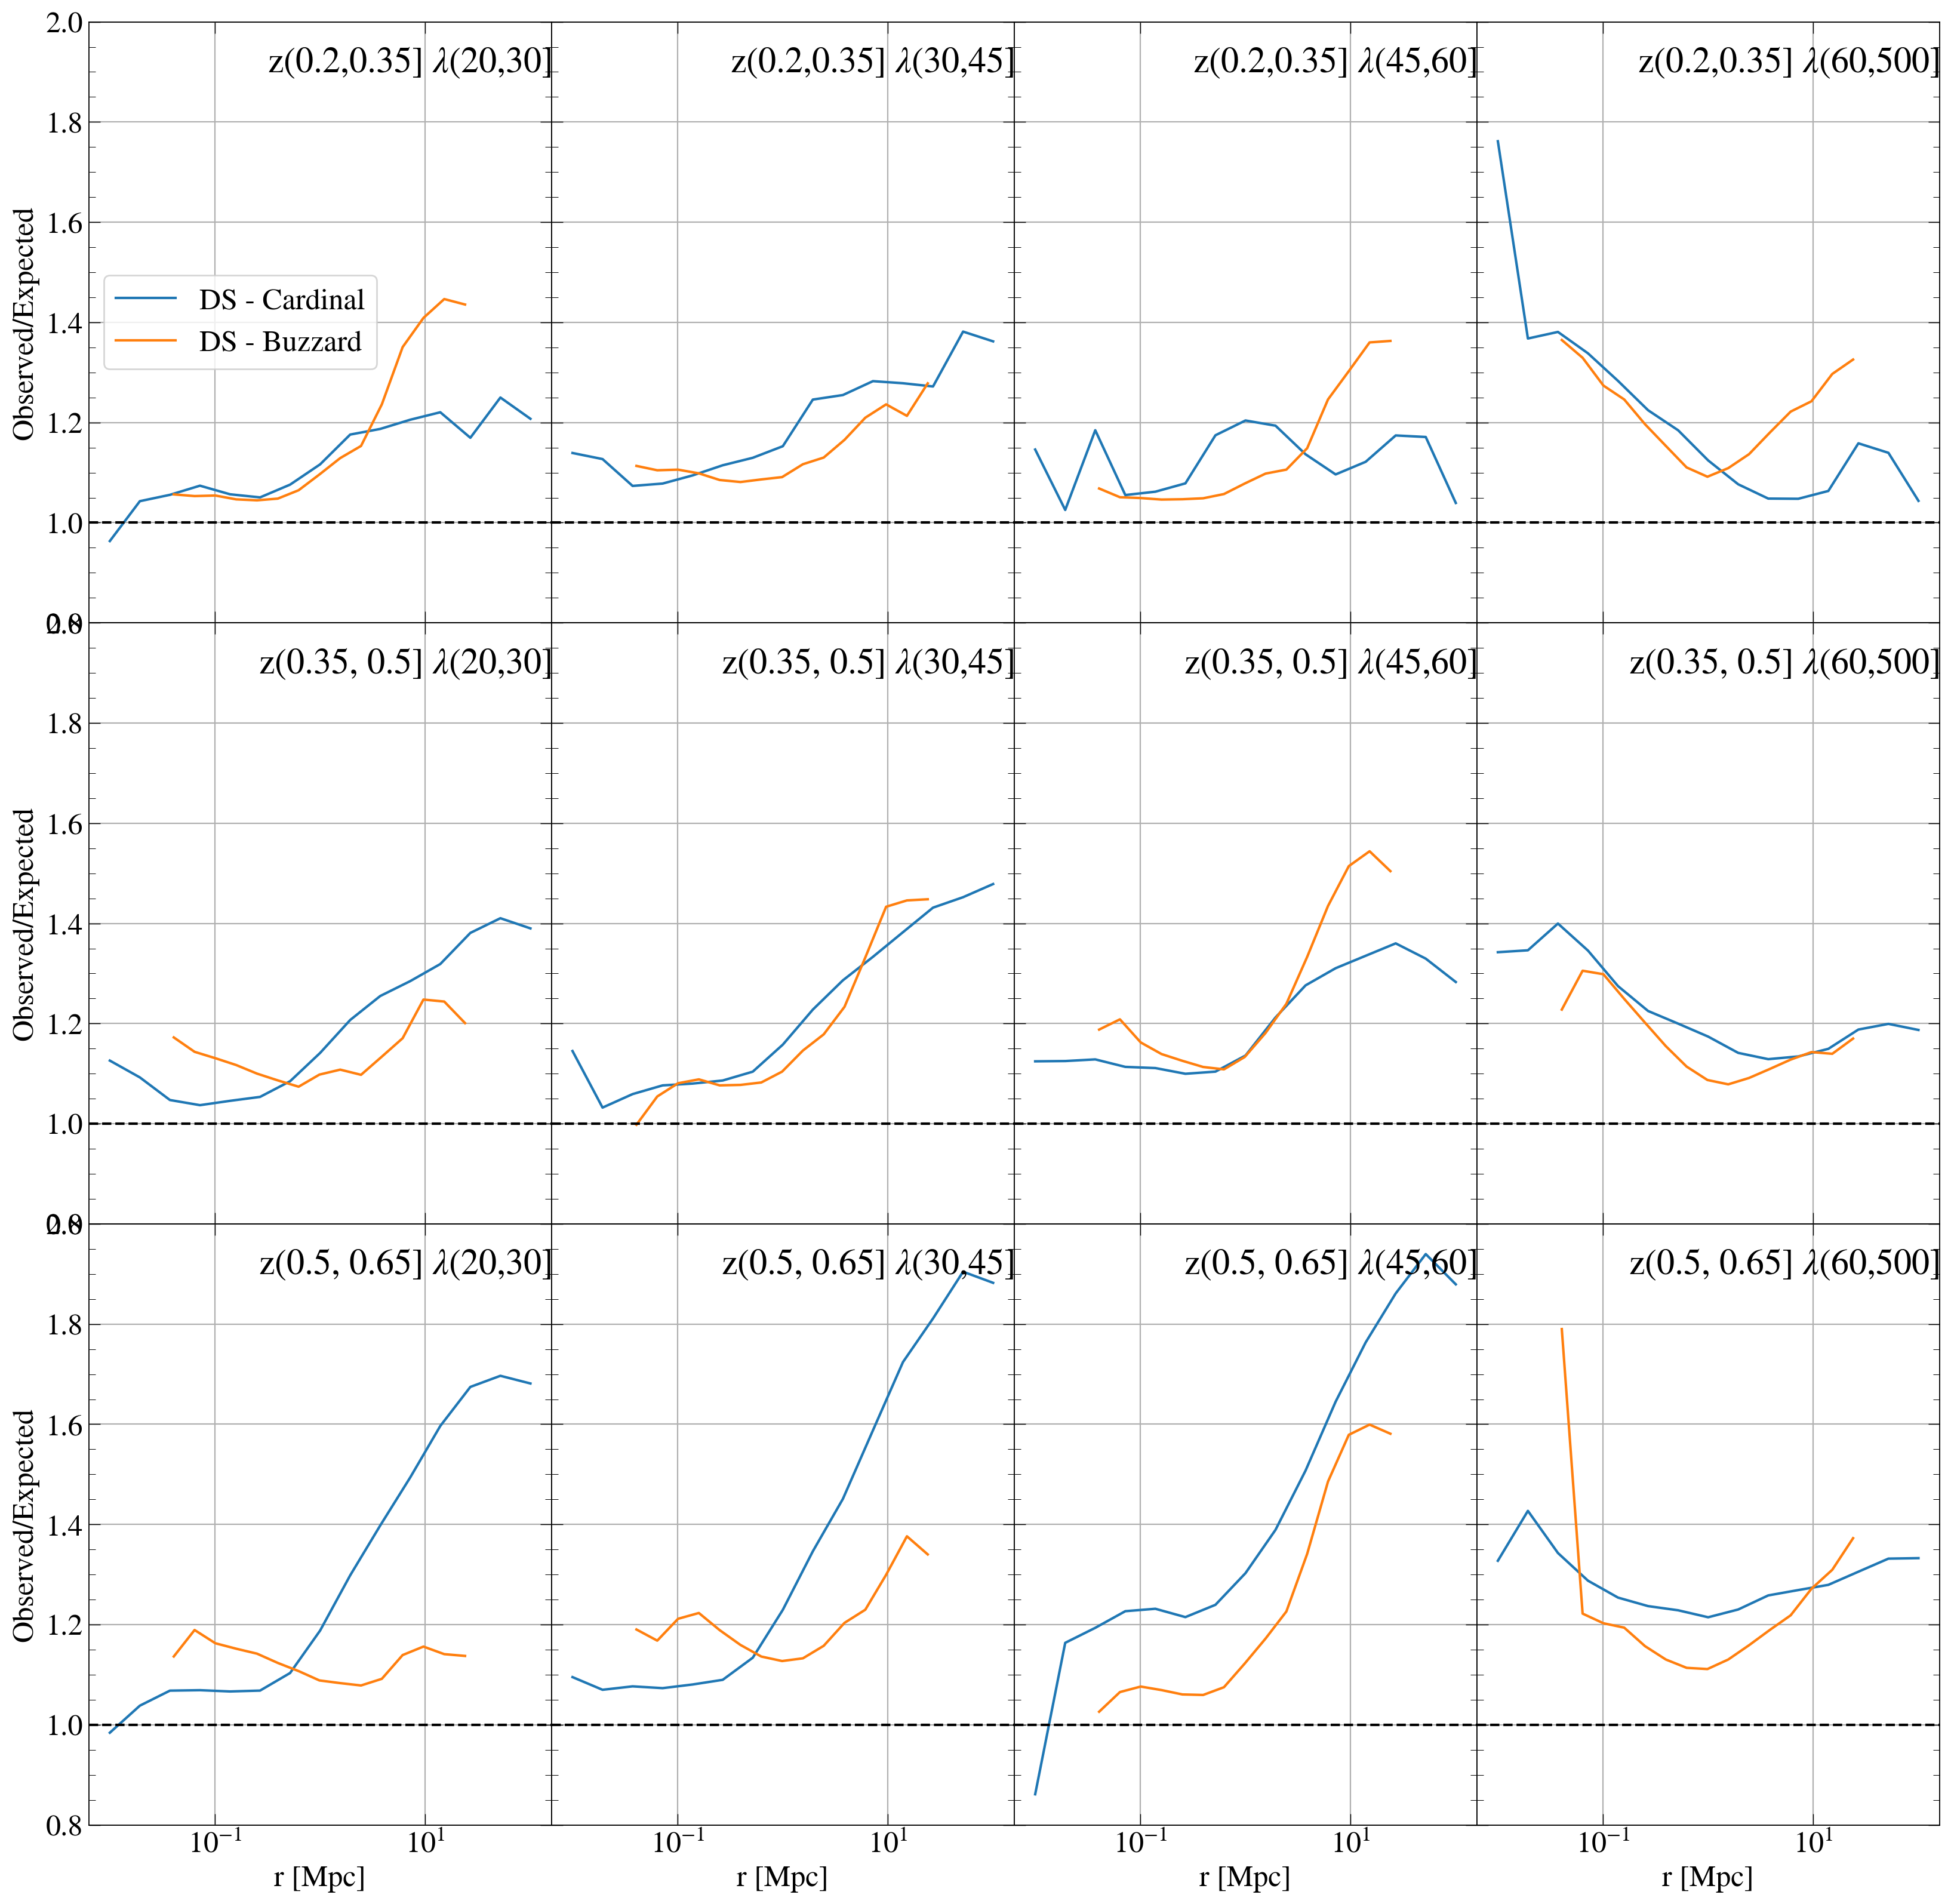

In [63]:
grouped_halos = halos2.group_by('redshift_range')
grouped_cl_halos = match2.group_by(['redshift_range','lambda_range'])
buzzard_ds = buzzard_ds.group_by(['redshift_range','lambda_range'])
# Get unique redshift groups
redshift_groups = sorted(np.unique(match2['redshift_range']))


# Create a figure with subplots
fig, axes = plt.subplots( len(redshift_groups), 4, figsize=(20, 20), sharex=True, sharey=True)

for Cl_H, buzzard in zip(grouped_cl_halos.groups, buzzard_ds.groups):  # matched clusters and halos
    for H in grouped_halos.groups:  # Underlying halos
        if Cl_H['redshift_range'][0] == H['redshift_range'][0]:
            lnM_sel = np.log10(Cl_H['Mvir'])
            z_sel = Cl_H['Redshift']
            profile_sel = Cl_H['Sigma']
            profile_sel_ds = Cl_H['DeltaSigma']

            lnM_All = np.log10(H['Mvir'])
            z_All = H['Redshift']
            profile_All = H['Sigma']
            profile_All_ds = H['DeltaSigma']
    
            # expected_sigma = stacked_profile_weighted_by_mass_redshift(lnM_sel, z_sel, profile_sel, lnM_All, z_All, profile_All, dm=0.1, dz=0.05)
            expected_ds = stacked_profile_weighted_by_mass_redshift(lnM_sel, z_sel, profile_sel_ds, lnM_All, z_All, profile_All_ds, dm=0.1, dz=0.05)

            # Extract numerical values from redshift and lambda group labels
            redshift_value = float(re.findall(r'\d+\.\d+', Cl_H['redshift_range'][0])[0])
            lambda_value = float(re.findall(r'\d+', Cl_H['lambda_range'][0])[0])

            # Calculate the row and column indices for the subplot
            row_index = redshift_groups.index(Cl_H['redshift_range'][0])
            col_index = int(lambda_value) // 15 - 1

            # Plot the lensing signal in the corresponding subplot
            ratio_ds = np.array(Cl_H['DeltaSigma'].mean(axis=0))/np.array(expected_ds)
            # ratio_sigma = np.array(Cl_H['Sigma'].mean(axis=0))/np.array(expected_sigma)
            # print(expected_sigma)

            axes[row_index, col_index].plot(bins, ratio_ds, label='DS - Cardinal')
            axes[row_index, col_index].plot(buzzard['r'], buzzard['ds_ratio'], label='DS - Buzzard')
            # axes[row_index, col_index].fill_between(buzzard['r'], buzzard['ds_ratio']+buzzard['err'], buzzard['ds_ratio']-buzzard['err'], alpha=0.2)
            # axes[row_index, col_index].axhline(y=1, color='k', linestyle='--')
            
            # axes[row_index, col_index].plot(bins, ratio_sigma, label='Sigma')
            # axes[row_index, col_index].fill_between(Cl_H['radius'].mean(), ratio_sigma - err_sigma, ratio_sigma + err_sigma, alpha=0.5)
            axes[row_index, col_index].axhline(y=1, color='k', linestyle='--')
             # Set xscale and yscale to log
            axes[row_index, col_index].set_xscale('log')
            # axes[row_index, col_index].set_yscale('log')

            axes[row_index, col_index].set_ylim(0.8, 2)

            axes[0, 0].legend(loc='center left')

            # Set the title inside the subplot
            ztitle = Cl_H['redshift_range'][0]
            lamtitle = Cl_H['lambda_range'][0]
            title = f'z{ztitle} $\lambda${lamtitle}'
            title_y = 1.1 if row_index > 3 else 0.9  # Adjust the y position for the last row
            axes[row_index, col_index].set_title(title,  loc='right', y=title_y)


# Adjust the spacing between subplots
plt.subplots_adjust(hspace=0, wspace=0)

# Share y-axis across all subplots
for ax in axes.flat:
    ax.label_outer()

# Set the x and y-axis labels for the bottom subplots
for ax in axes[-1, :]:
    ax.set_xlabel('r [Mpc]')
for ax in axes[:, 0]:
    ax.set_ylabel('Observed/Expected')

# plt.legend()
plt.savefig('Images/SBiasCardinal-Buzzard.png', facecolor='white')
plt.show()